In [1]:
import os
import re
import sys

import pathlib
from pathlib import Path

import sqlite3

import pandas as pd
import numpy as np

from scipy import stats

import math

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns

from IPython.display import display

from copy import deepcopy
import logging as log

import pickle
import xlrd
import xlwt
import pylab

In [2]:
# Helper (support)
from support import input_helper

In [3]:
# Directory with IGU datasets:
ROOT_DIR = "RawData"

# Define path to save figures:
path_img = os.path.abspath(os.path.join('outputs', 'IMG'))
if not os.path.exists(path_img):
    os.makedirs(path_img)
print(f'Images will be saved in {path_img}')

Images will be saved in C:\Users\souvi\Documents\These\80_Calculations\02_MFA_IGU\outputs\IMG


In [4]:
# Define size of figure:
mpl.rcParams['figure.figsize'] = (16, 10)

In [5]:
# Define seaborn main parameters:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("paper", font_scale=1.5,
                rc={"axes.titlesize": 15, "lines.linewidth": 1.2,
                    "legend.fontsize": 10, "legend.title_fontsize": 10})

In [6]:
pd.set_option('precision', 2)

In [7]:
# A custom formatter function which divide by 1000 an axis:
import matplotlib.ticker as tkr


def yfmt1000(x, pos):
    s = f'{x/1000:,.0f}'
    return s

# W/ classes for tick-locating and -formatting:


# A formatter function:
y_1000 = tkr.FuncFormatter(yfmt1000)

# To divide the y-axis by 1000 when needed:
# ax.yaxis.set_major_formatter(y_1000)

In [8]:
# A function used to define the thickness of x and y axis:
def style_ax(ax):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.tick_params(width=0.5)
        ax.set_xlabel(None)
    return ax

In [9]:
# A keyword to export figures, or not:
export = False

# Upload Datasets

In [10]:
# Belgian dataset:
be_data = input_helper.get_data(
    'BE_IGU_RawData_VPython.xlsx', directory=ROOT_DIR)

# French dataset:
fr_data = input_helper.get_data(
    'FR_IGU_RawData_VPython.xlsx', directory=ROOT_DIR)

# European dataset:
eu_data = input_helper.get_data(
    'eu_igu_RawData_VPython.xlsx', directory=ROOT_DIR)

In [11]:
print("be_data, sheet names = \n {}\n".format(be_data.sheet_names))
print("fr_data, sheet names = \n {}\n".format(fr_data.sheet_names))
print("eu_data, sheet names = \n {}\n".format(eu_data.sheet_names))

be_data, sheet names = 
 ['References', 'consumption', 'prod', 'import', 'export', 'thickness', 'Energy_Intensity', 'Population']

fr_data, sheet names = 
 ['References', 'consumption', 'prod', 'import', 'export', 'Population', 'thickness', 'RawMat_Intensity', 'Energy_Intensity', 'emissions']

eu_data, sheet names = 
 ['References', 'stock', 'prod', 'import', 'export', 'thickness', 'emissions', 'Energy_Intensity']



# Material, Energy and Carbon Intensity in the Flat Glass Industry

See: Souviron J and A Z Khan. (Forthcoming). "The Materiality of Transparency: An Environmental Analysis of the Architectural Flat Glass Industry since 1945 in Europe, France and Belgium". _Resources, Conservation and Recycling_.

## Material Intensity since 1945, France

In [12]:
# Creating a DataFrame for material intensity:
df_rawmat = fr_data.parse('RawMat_Intensity').set_index('year')

df_rawmat['cullet, kg/kg'] = (df_rawmat['internal cullet, kg/kg']
                              + df_rawmat['external cullet, kg/kg'])

In [13]:
# Estimating total material intensity (sum of the intensities per material):
materials = ['sand', 'cullet', 'sodium carbonate',
             'limestone', 'dolomite', 'feldspar']
print(materials)

df_rawmat['Total raw materials, kg/kg'] = 0
for mat in materials:
    df_rawmat['Total raw materials, kg/kg'] = (
        df_rawmat[f"{mat}, kg/kg"]
        + df_rawmat['Total raw materials, kg/kg']
    )

['sand', 'cullet', 'sodium carbonate', 'limestone', 'dolomite', 'feldspar']


In [14]:
# Estimate the material intensity without cullet:
materials.remove('cullet')
df_rawmat['Total raw mat w/o cullet, kg/kg'] = 0
for mat in materials:
    df_rawmat['Total raw mat w/o cullet, kg/kg'] = (
        df_rawmat[f"{mat}, kg/kg"]
        + df_rawmat['Total raw mat w/o cullet, kg/kg']
    )

materials = ['sand', 'cullet', 'sodium carbonate',
             'limestone', 'dolomite', 'feldspar']

## Energy Intensity since 1945, France and Belgium

In [15]:
# Create a DataFrame for the energy intensity in France:
df_fr_energy = fr_data.parse('Energy_Intensity').set_index('year')
df_be_energy = be_data.parse('Energy_Intensity').set_index('year')

# Create a unique DataFrame for FR and BE flat glass flows:
df_be_fr_energy = pd.concat(
    [df_fr_energy['fuel oil, GJ/t'],
     df_be_energy['fuel oil, GJ/t'],
     df_fr_energy['natural gas, GJ/t'],
     df_be_energy['natural gas, GJ/t'],
     df_fr_energy['electricity, GJ/t'],
     df_be_energy['electricity, GJ/t']],
    axis=1, keys=[('fuel oil, GJ/t', 'France'),
                  ('fuel oil, GJ/t', 'Belgium'),
                  ('natural gas, GJ/t', 'France'),
                  ('natural gas, GJ/t', 'Belgium'),
                  ('electricity, GJ/t', 'France'),
                  ('electricity, GJ/t', 'Belgium')],
    names=['Info', 'Country']
).stack(dropna=False)

df_be_fr_energy = df_be_fr_energy.unstack()

In [16]:
energies = ['fuel oil', 'natural gas', 'electricity']
fossilfuels = ['fuel oil', 'natural gas']
countries = ['Belgium', 'France']

In [17]:
# Estimate the total energy intensity
# (sum of the intensities per type of energy):
for country in countries:
    df_be_fr_energy[('Total energy, GJ/t', country)] = 0
    for energy in energies:
        df_be_fr_energy[('Total energy, GJ/t', country)] = (
            df_be_fr_energy[('Total energy, GJ/t', country)]
            + df_be_fr_energy[(f"{energy}, GJ/t", country)]
        )

In [18]:
# Estimate the total energy intensity
# (without electricity)
for country in countries:
    df_be_fr_energy[('Total energy w/o elec., GJ/t', country)] = 0
    for energy in fossilfuels:
        df_be_fr_energy[('Total energy w/o elec., GJ/t', country)] = (
            df_be_fr_energy[(
                'Total energy w/o elec., GJ/t', country)]
            + df_be_fr_energy[(f"{energy}, GJ/t", country)]
        )

## Energy Intensity in the EU since 1970

In [19]:
# Create a DataFrame for the energy intensity in the EU:
df_eu_energy = eu_data.parse('Energy_Intensity').set_index('year')

In [20]:
# Estimate the total energy intensity
# (sum of the intensities per type of energy)
# In Europe:
df_eu_energy['Total energy, GJ/t'] = 0

for energy in energies:
    df_eu_energy['Total energy, GJ/t'] = (
        df_eu_energy['Total energy, GJ/t']
        + df_eu_energy[f"{energy}, GJ/t"]
    )

In [21]:
# Estimate the total energy intensity
# (without electricity)
df_eu_energy['Total energy w/o elec., GJ/t'] = 0

for energy in fossilfuels:
    df_eu_energy['Total energy w/o elec., GJ/t'] = (
        df_eu_energy['Total energy w/o elec., GJ/t']
        + df_eu_energy[f"{energy}, GJ/t"]
    )

## Carbon Intensity of the Flat Glass Manufacturing Process in France

In [22]:
# Create a DataFrame only with the CO2 emission data:
fr_emissions = fr_data.parse('emissions').set_index('year')

fr_co2_intensity = fr_emissions[['CO2 glass ind, kg/t']].copy()
fr_co2_intensity.rename(columns={'CO2 glass ind, kg/t': 'CO2 [kg/t]'},
                        inplace=True)

In [23]:
# Interpolate CO2 intensity accoring to a pchip method:
fr_co2_intensity['CO2 interpolated [kg/t]'] = (
    fr_co2_intensity['CO2 [kg/t]'].interpolate('pchip')
)

## Carbon Intensity of the Flat Glass Manufacturing Process in the EU

In [24]:
# Create a DataFrame only with the CO2 emission data:
df_eu_emissions = eu_data.parse('emissions').set_index('year')

df_eu_co2 = df_eu_emissions[['CO2 glass ind, kg/t']].copy()
df_eu_co2.rename(columns={'CO2 glass ind, kg/t': 'CO2 [kg/t]'},
                 inplace=True)

In [25]:
# Interpolate CO2 intensity accoring to a pchip method:
df_eu_co2['CO2 interpolated [kg/t]'] = (
    df_eu_co2['CO2 [kg/t]'].interpolate('pchip')
)

## Summary

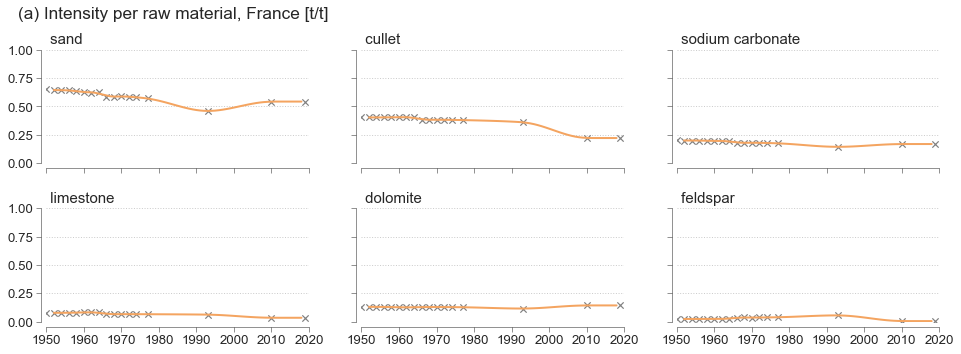

In [26]:
# Plot the material instensity per raw material:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    (df_rawmat[f"{mat}, kg/kg"]
     .interpolate(method='pchip', limit_direction='forward')
     .rolling(5, center=True).mean()
     .plot(ax=ax, c='sandybrown', linewidth=2))

    ax.scatter(x=df_rawmat.index, y=df_rawmat[f"{mat}, kg/kg"],
               s=40, marker='x', c='grey')
    plt.xticks(np.arange(1950, 2021, 10), rotation=45)

    ax.set_title(f" {mat}", loc='left')
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))

fig.suptitle(
    "(a) Intensity per raw material, France [t/t]", x=0.1, y=1, ha='left')

fig.subplots_adjust(wspace=0.2, hspace=0.4)

sns.despine(offset=5)

plt.show()

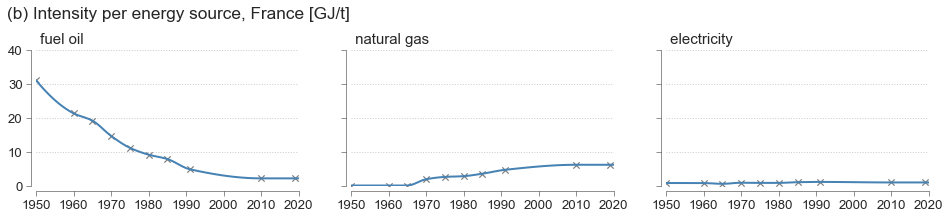

In [27]:
# Plot the energy intensity per source of energy, France:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 2.5)
                         )

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    (df_be_fr_energy[(f"{energy}, GJ/t", "France")]
     .interpolate(method='pchip', limit_direction='forward')
     .plot(ax=ax, color='steelblue', linewidth=2))

    ax.scatter(x=df_be_fr_energy.index,
               y=df_be_fr_energy[(f"{energy}, GJ/t", "France")],
               s=40, marker='x', c='grey')

    ax.set_title(f" {energy}", loc='left')
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 40)

fig.suptitle("(b) Intensity per energy source, France [GJ/t]",
             x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.2)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))

sns.despine(offset=5)

plt.show()

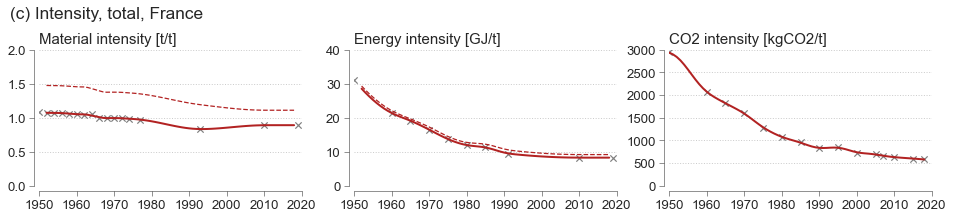

In [28]:
# Plot the intensity for energy, material and CO2 emissions:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True,
                         figsize=(16, 2.5))

# Material intensity
ax = axes[0]
(df_rawmat['Total raw materials, kg/kg']
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linestyle='--', linewidth=1.25)
 )

(df_rawmat['Total raw mat w/o cullet, kg/kg']
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linestyle='-', linewidth=2)
 )

ax.scatter(x=df_rawmat.index,
           y=df_rawmat['Total raw mat w/o cullet, kg/kg'],
           s=40, marker='x', c='grey')

ax.set_title("Material intensity [t/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 2)
ax.set_xlim(1950, 2020)

# Energy intensity
ax = axes[1]
(df_be_fr_energy[('Total energy, GJ/t', 'France')]
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linestyle='--', linewidth=1.25))

(df_be_fr_energy[('Total energy w/o elec., GJ/t', 'France')]
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linewidth=2))

ax.scatter(x=df_be_fr_energy.index,
           y=df_be_fr_energy[(
               'Total energy w/o elec., GJ/t', 'France')],
           s=40, marker='x', c='grey')

ax.set_title("Energy intensity [GJ/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 40)

# Carbon dioxide intensity
ax = axes[2]
(fr_co2_intensity['CO2 interpolated [kg/t]'].rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linewidth=2))

ax.scatter(x=fr_co2_intensity.index, y=fr_co2_intensity['CO2 [kg/t]'],
           s=40, marker='x', c='grey')

ax.set_title("CO2 intensity [kgCO2/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 3000)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))
plt.yticks(np.arange(0, 3001, 500))

fig.suptitle("(c) Intensity, total, France", x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.20)

sns.despine(offset=5)

plt.show()

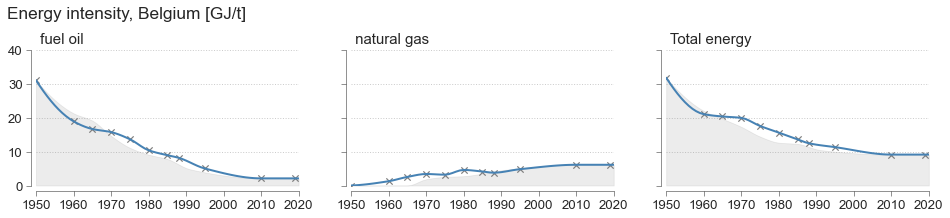

In [29]:
toplot = ['fuel oil', 'natural gas', 'Total energy']

# Plot the energy intensity for Belgium:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 2.5)
                         )

for i, (ax, plot) in enumerate(zip(axes.flatten(), toplot)):
    (df_be_fr_energy[(f"{plot}, GJ/t", "Belgium")]
     .interpolate(method='pchip', limit_direction='forward')
     .plot(ax=ax, color='steelblue', linewidth=2))

    ax.scatter(x=df_be_fr_energy.index,
               y=df_be_fr_energy[(f"{plot}, GJ/t", "Belgium")],
               s=40, marker='x', c='grey')

    x = (df_be_fr_energy.reset_index()['year'])
    y = (df_be_fr_energy[(f"{plot}, GJ/t", "France")]
         .interpolate(method='pchip', limit_direction='forward'))
    ax.fill_between(x, y, color="grey", alpha=0.15)

    ax.set_title(f" {plot}", loc='left')
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 40)

fig.suptitle("Energy intensity, Belgium [GJ/t]",
             x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.2)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))

sns.despine(offset=5)

plt.show()

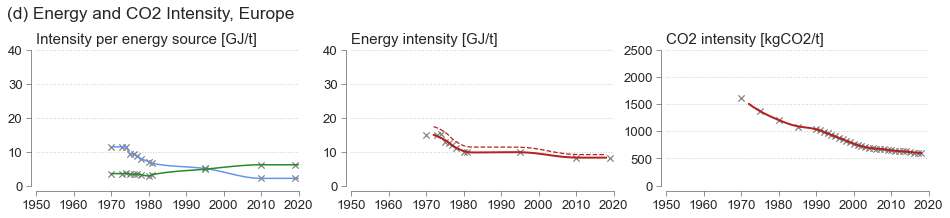

In [30]:
# Plot the intensity for energy, material and CO2 emissions:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True,
                         figsize=(16, 2.5))

# Intensity, per energy source
ax = axes[0]
(df_eu_energy["fuel oil, GJ/t"]
 .interpolate(method='pchip', limit_direction='forward')
 .plot(ax=ax, color='cornflowerblue', linestyle='-', linewidth=1.5))

ax.scatter(x=df_eu_energy.index,
           y=df_eu_energy["fuel oil, GJ/t"],
           s=40, marker='x', c='grey')

(df_eu_energy["natural gas, GJ/t"]
 .interpolate(method='pchip', limit_direction='forward')
 .plot(ax=ax, color='forestgreen', linewidth=1.5, linestyle='-'))

ax.scatter(x=df_eu_energy.index,
           y=df_eu_energy["natural gas, GJ/t"],
           s=40, marker='x', c='grey')

ax.set_title("Intensity per energy source [GJ/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 40)
ax.set_xlim(1950, 2020)

# Energy intensity, total
ax = axes[1]
(df_eu_energy['Total energy, GJ/t']
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linestyle='--', linewidth=1.25))

(df_eu_energy['Total energy w/o elec., GJ/t']
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linewidth=2))

ax.scatter(x=df_eu_energy.index,
           y=df_eu_energy['Total energy w/o elec., GJ/t'],
           s=40, marker='x', c='grey')

ax.set_title("Energy intensity [GJ/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 40)

# Carbon dioxide intensity
ax = axes[2]
(df_eu_co2['CO2 interpolated [kg/t]'].rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linewidth=2))

ax.scatter(x=df_eu_co2.index, y=df_eu_co2['CO2 [kg/t]'],
           s=40, marker='x', c='grey')

ax.set_title("CO2 intensity [kgCO2/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 2500)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))

fig.suptitle("(d) Energy and CO2 Intensity, Europe", x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.20)

sns.despine(offset=5)

plt.show()

# Flows of IGU in Europe

## Creating a Dataframe for the Flows of IGU

In [31]:
# DataFrame relating to IGU production:
df_eu_prod = eu_data.parse('prod').set_index(['Nbr of countries', 'year'])

In [32]:
# Add import and export flows:
df_eu_imp = eu_data.parse('import').set_index(['Nbr of countries', 'year'])
df_eu_exp = eu_data.parse('export').set_index(['Nbr of countries', 'year'])

In [33]:
# Create a single dataframe for flows of IGU in the EU:
df_eu = pd.concat([df_eu_prod['IGU, "000 m²']/1000,
                   df_eu_imp['IGU, "000 m²']/1000,
                   df_eu_exp['IGU, "000 m²']/1000,
                   ],
                  axis=1, keys=[('Production', '[10^6 m²]'),
                                ('Import', '[10^6 m²]'),
                                ('Export', '[10^6 m²]')
                                ],
                  names=['Info', 'Unit']).stack(dropna=False)

df_eu = df_eu.unstack()

In [34]:
df_eu.style

## Weighing the Flows of IGU

In [35]:
# DataFrame relating to IGU avrage thickness:
df_eu_thick = eu_data.parse('thickness').set_index(
    ['Nbr of countries', 'year'])

In [36]:
df_eu_thick.dropna(inplace=False)

average thickness, mm  min. thickness, mm  \
Nbr of countries year                                              
6                1947                    8.0                 6.0   
                 1955                    8.0                 6.0   
27               2005                   10.0                 8.0   
28               2019                   11.0                10.0   

                       max. thickness, mm  
Nbr of countries year                      
6                1947                11.0  
                 1955                11.0  
27               2005                12.0  
28               2019                12.0

In [37]:
# Linear interpolation according to available data:
df_eu_thick = (df_eu_thick.interpolate(method="linear", limit_area='inside'))

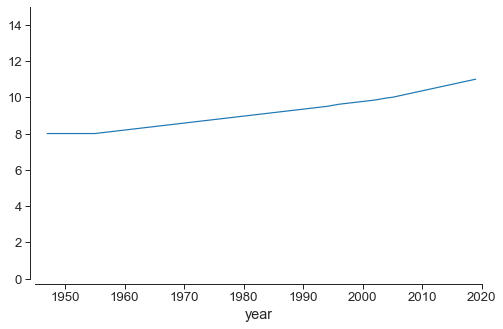

In [38]:
# Plot evolution of total glass thickness in IGUs:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df_eu_thick.reset_index(),
             x='year', y='average thickness, mm',
             ax=ax)

ax.yaxis.label.set_visible(False)
ax.set_xlim(1945, 2020)
ax.set_ylim(0, 15)

sns.despine(offset=5)

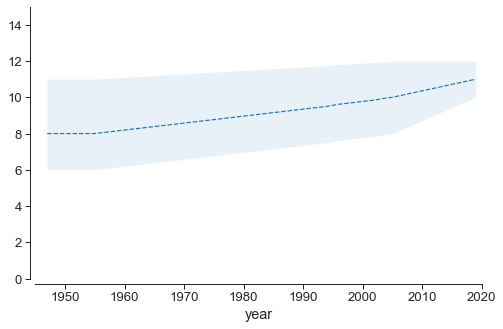

In [39]:
# Taking into acount uncertainty, with min. and max. average thickness
# Plot evolution of total glass thickness in IGUs w/ uncertainty:
df_toplot = df_eu_thick.reset_index('Nbr of countries').drop(
    labels='Nbr of countries', axis=1)

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df_toplot['average thickness, mm'],
             linestyle='--', ax=ax)

ax.fill_between(df_toplot.index, df_toplot['max. thickness, mm'],
                df_toplot['min. thickness, mm'],
                alpha=0.10)

ax.yaxis.label.set_visible(False)
ax.set_xlim(1945, 2020)
ax.set_ylim(0, 15)

sns.despine(offset=5)

In [40]:
levels = ['average', 'min.', 'max.']

In [41]:
# Adding columns for IGU flows in [kt],
# to be used later for material/energy/carbon intensity

for level in levels:
    for flow in ['Import', 'Export', 'Production']:
        df_eu[(f'{flow}', f'[kt], {level}')] = (
            df_eu[(f'{flow}', '[10^6 m²]')] *
            df_eu_thick[f'{level} thickness, mm'] * 2.5)

In [42]:
df_eu = df_eu.sort_index(axis=1)

## Production of Insulating Glass Units

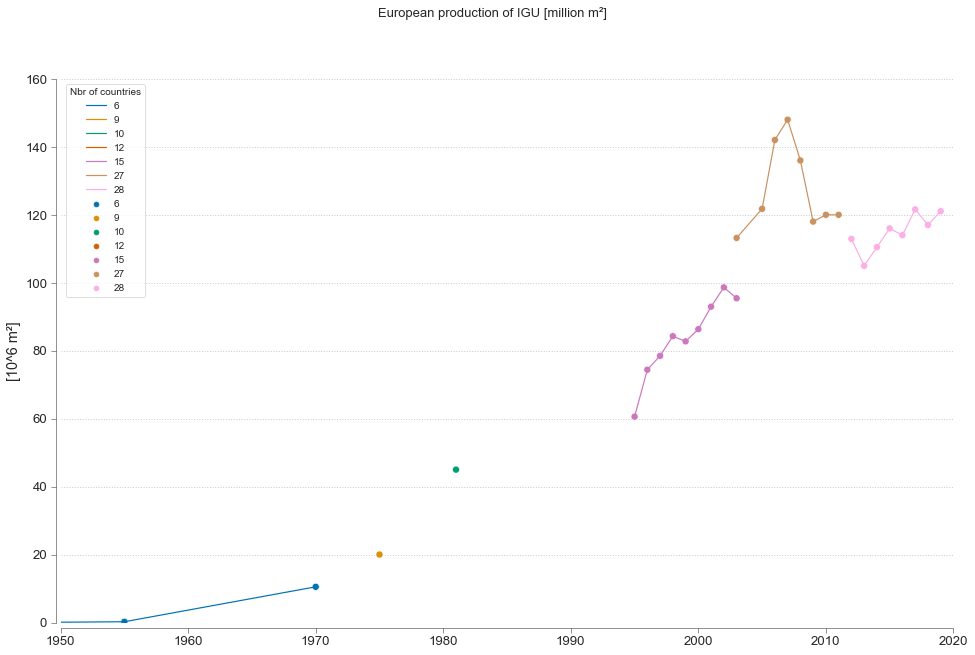

In [43]:
# Plot the European production of IGU
fig, ax = plt.subplots()

sns.scatterplot(data=df_eu['Production'].reset_index(),
                x='year', y='[10^6 m²]',
                hue='Nbr of countries',
                palette='colorblind', s=50,
                ax=ax)

sns.lineplot(data=df_eu['Production'].reset_index(),
             x='year', y='[10^6 m²]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 160)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)

fig.suptitle('European production of IGU [million m²]', fontsize=13)
sns.despine(offset=5)
plt.show()

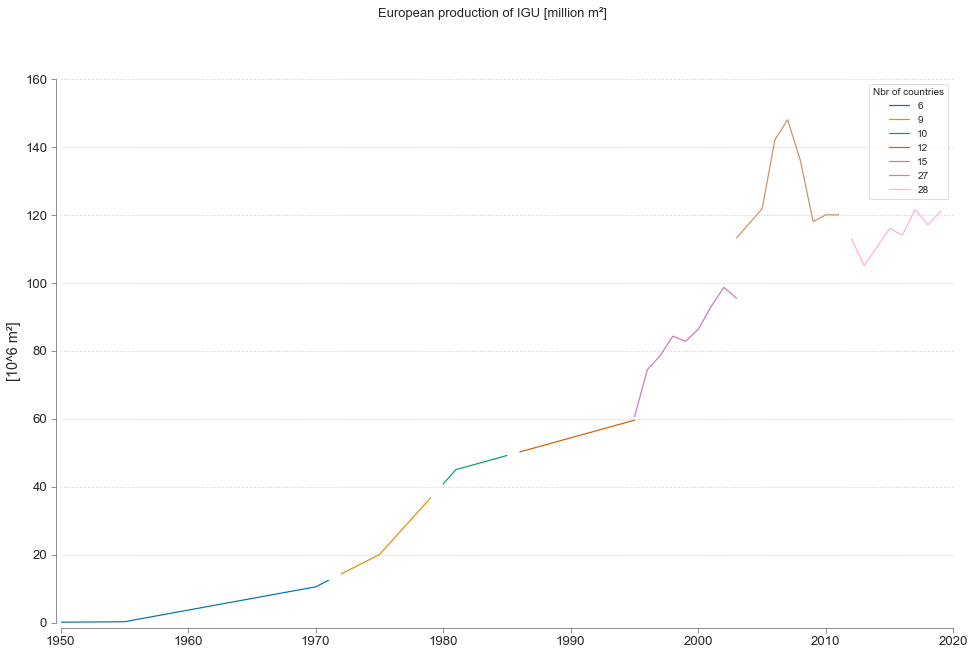

In [44]:
# Plot the European production of IGU:
fig, ax = plt.subplots()

sns.lineplot(data=(df_eu['Production']
                   .interpolate(method='linear').reset_index()),
             x='year', y='[10^6 m²]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 160)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)

fig.suptitle('European production of IGU [million m²]', fontsize=13)
sns.despine(offset=5)
plt.show()

## Consumption of Insulating Glass Units

In [45]:
# Estimate the consumption of IGU in the EU:
df_eu = df_eu.stack(dropna=False)

df_eu['Consumption'] = (df_eu['Production']
                        + df_eu['Import']
                        - df_eu['Export']
                        )

df_eu = df_eu.unstack()

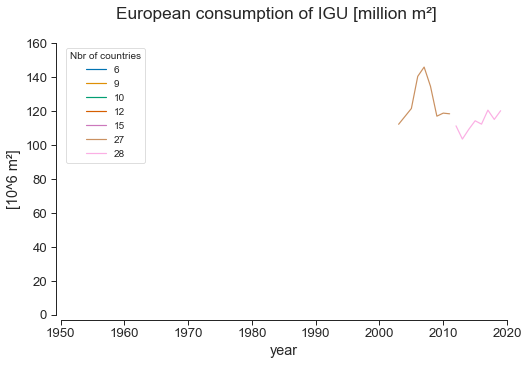

In [46]:
# Plot the European consumption of IGU:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df_eu['Consumption'].reset_index(),
             x='year', y='[10^6 m²]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 160)

fig.suptitle('European consumption of IGU [million m²]')
sns.despine(offset=5)
plt.show()

## Summary

In [47]:
# Assess the annual growth:
df_eu[('Growth, prod', '[%]')] = df_eu[(
    'Production', '[10^6 m²]')].pct_change()

In [48]:
df_eu.loc[(slice(None), slice(2003, 2020)), :]

Info                     Export                                        Import  \
Unit                  [10^6 m²] [kt], average [kt], max. [kt], min. [10^6 m²]   
Nbr of countries year                                                           
15               2003       NaN           NaN        NaN        NaN       NaN   
27               2003      1.72         42.73      51.51      34.12      0.51   
                 2004      1.54         38.47      46.27      30.75      0.65   
                 2005      1.33         33.15      39.78      26.52      0.81   
                 2006      2.64         66.50      79.23      53.77      0.81   
                 2007      3.15         79.85      94.47      65.23      0.80   
                 2008      2.42         61.87      72.69      51.05      0.73   
                 2009      1.87         48.04      56.05      40.03      0.62   
                 2010      2.03         52.46      60.78      44.14      0.58   
                 2011      2.48         64.67      74.41      54.92      0.62   
28               2012      2.57         67.53      77.17      57.88      0.72   
                 2013      2.47         65.35      74.18      56.52      0.73   
                 2014      2.63         69.94      78.86      61.02      1.14   
                 2015      2.83         75.90      85.01      66.80      0.87   
                 2016      2.94         79.31      88.24      70.38      1.00   
                 2017      3.41         92.47     102.20      82.74      2.12   
                 2018      3.20         87.31      95.87      78.75      1.02   
                 2019      3.42         93.92     102.46      85.39      2.32   

Info                                                      Production  \
Unit                  [kt], average [kt], max. [kt], min.  [10^6 m²]   
Nbr of countries year                                                  
15               2003           NaN        NaN        NaN      95.43   
27               2003         12.64      15.24      10.09     113.19   
                 2004         16.09      19.36      12.86        NaN   
                 2005         20.34      24.41      16.27     121.77   
                 2006         20.39      24.30      16.49     142.03   
                 2007         20.40      24.14      16.67     148.00   
                 2008         18.70      21.97      15.43     136.00   
                 2009         15.90      18.56      13.25     118.00   
                 2010         14.95      17.32      12.58     120.00   
                 2011         16.26      18.71      13.81     120.00   
28               2012         18.96      21.66      16.25     112.90   
                 2013         19.26      21.87      16.66     105.00   
                 2014         30.38      34.26      26.51     110.47   
                 2015         23.41      26.22      20.60     116.00   
                 2016         27.01      30.06      23.97     114.00   
                 2017         57.48      63.53      51.43     121.60   
                 2018         27.86      30.59      25.13     117.01   
                 2019         63.74      69.54      57.95     121.06   

Info                                                      Consumption  \
Unit                  [kt], average [kt], max. [kt], min.   [10^6 m²]   
Nbr of countries year                                                   
15               2003       2358.11    2849.00    1880.98         NaN   
27               2003       2808.05    3384.90    2242.09      111.98   
                 2004           NaN        NaN        NaN         NaN   
                 2005       3044.24    3653.08    2435.39      121.26   
                 2006       3576.03    4260.80    2891.26      140.20   
                 2007       3752.86    4440.00    3065.71      145.66   
                 2008       3472.86    4080.00    2865.71      134.31   
                 2009       3034.29    3540.00    2528.

In [49]:
n_countries = df_eu.index.get_level_values(0).unique()

for i, start_n_countries in enumerate(n_countries[:-1]):
    if start_n_countries < 10:
        continue
    end_n_countries = n_countries[i+1]
    start_year = df_eu.loc[start_n_countries].index.max()
    end_year = df_eu.loc[end_n_countries].index.max()
    a = df_eu.loc[start_n_countries:end_n_countries,
                  ('Growth, prod', '[%]')].mean()*100

    print(
        f'Years {start_year}-{end_year} ({start_n_countries} to {end_n_countries} countries)')
    print(f'IGU production growth in EU: {a:.2f}%\n')
    print('')

Years 1985-1995 (10 to 12 countries)
IGU production growth in EU: 7.81%


Years 1995-2003 (12 to 15 countries)
IGU production growth in EU: 4.39%


Years 2003-2011 (15 to 27 countries)
IGU production growth in EU: 6.15%


Years 2011-2019 (27 to 28 countries)
IGU production growth in EU: 1.72%




In [50]:
n_countries

Int64Index([6, 9, 10, 12, 15, 27, 28], dtype='int64', name='Nbr of countries')

In [254]:
# Key dates for the changes in the MFA scope, i.e. EU enlargement:
EU_KDATES = {'EU6': 1957, 'EU9': 1972, 'EU12': 1986,
             'EU15': 1995, 'EU27': 2003, 'EU28': 2012}

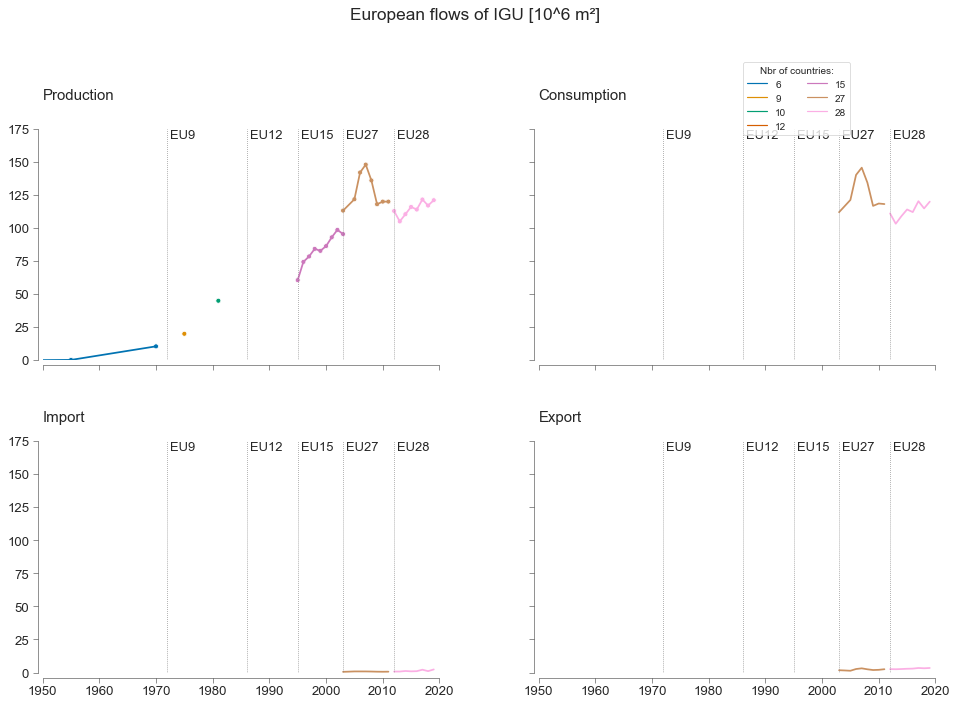

In [52]:
# Plot a synthesis of the results concerning European flows of IGU:
data1 = ['Production', 'Consumption']
data2 = ['Import', 'Export']

fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 10))

# Plot production and consumption:
for col, data in enumerate(data1):
    ax = axes[0][col]
    sns.lineplot(data=df_eu[f"{data}"].reset_index(),
                 x='year', y="[10^6 m²]",
                 hue='Nbr of countries',
                 palette='colorblind', linewidth=1.75,
                 ax=ax)

    # Plot lines highlighting changes in the scope, i.e., EU enlargement:
    for y, x in EU_KDATES.items():
        ax.axvline(x=x, c='grey', linestyle=':', linewidth=0.75)
        ax.text(x+0.5, 175, f"{y}", fontsize=13,
                verticalalignment='top')

    if col == 0:
        # Plot data gathered from literature review:
        sns.scatterplot(data=df_eu[f"{data}"].reset_index(),
                        x='year', y="[10^6 m²]",
                        hue='Nbr of countries',
                        palette='colorblind',
                        marker='.', s=100,
                        ax=ax)

    ax.get_legend().remove()
    style_ax(ax)

    ax.set_title(f"{data}", pad=30, loc='left')
    #ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    # ax.get_legend().remove()
    ax.yaxis.label.set_visible(False)

# Plot import and export below:
for col, data in enumerate(data2):
    ax = axes[1][col]
    sns.lineplot(data=df_eu[f"{data}"].reset_index(),
                 x='year', y="[10^6 m²]",
                 hue='Nbr of countries',
                 palette='colorblind', linewidth=1.75,
                 ax=ax)

    # Plot lines highlighting changes in the scope, i.e., EU enlargement:
    for y, x in EU_KDATES.items():
        ax.axvline(x=x, c='grey', linestyle=':', linewidth=0.75)
        ax.text(x+0.5, 175, f"{y}", fontsize=13,
                verticalalignment='top')

    style_ax(ax)

    ax.set_title(f"{data}", pad=20, loc='left')
    #ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    ax.get_legend().remove()
    ax.yaxis.label.set_visible(False)


# Add legend:
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=2,
           title='Nbr of countries:',
           bbox_to_anchor=(0.83, 0.98))

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 175)

fig.suptitle("European flows of IGU [10^6 m²]", y=1.05)
fig.subplots_adjust(wspace=0.25, hspace=0.35)

sns.despine(offset=5)
plt.show()

Hypothesis for missing data: EU production = EU consumption

In [53]:
df_eu = df_eu.stack(dropna=False)
df_eu['Estimated consumption'] = (df_eu['Consumption']
                                  .fillna(df_eu['Production']))

df_eu = df_eu.unstack()

In [54]:
# Number of countries for trend curves:
EU_COUNTRIES = [(6, 12), (15, 15), (27, 28)]

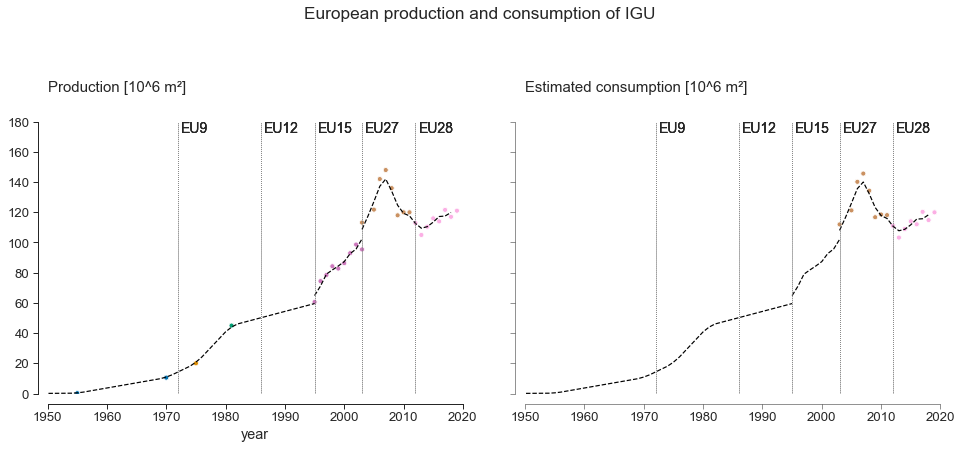

In [211]:
# Plot two figures:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for col, data in enumerate(['Production', 'Estimated consumption']):
    for i, j in EU_COUNTRIES:
        ax = axes[col]
        # Plot the trend curve for IGU production:
        ax.plot(df_eu.interpolate().rolling(3, center=True).mean().loc[i:j]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [(f"{data}", "[10^6 m²]")],
                c='black', linestyle='--')

        if col == 0:
            # Plot data gathered from literature review:
            sns.scatterplot(data=df_eu["Production"].reset_index(),
                            x='year', y="[10^6 m²]",
                            hue='Nbr of countries',
                            palette='colorblind',
                            marker='.', s=100,
                            ax=ax)
            
        else:
            # Plot data gathered from literature review:
            sns.scatterplot(data=df_eu["Consumption"].reset_index(),
                            x='year', y="[10^6 m²]",
                            hue='Nbr of countries',
                            palette='colorblind',
                            marker='.', s=100,
                            ax=ax)

        # Plot lines highlighting changes in the scope, i.e., EU enlargement:
        for y, x in EU_KDATES.items():
            ax.axvline(x=x, c='grey', linestyle=':', linewidth=0.75)
            ax.text(x+0.5, 180, f"{y}", fontsize=14,
                    verticalalignment='top')

        ax.get_legend().remove()
        ax.set_title(f'{data} [10^6 m²]', pad=30, loc='left')

style_ax(ax)
ax.set_xlim(1950, 2020)
ax.set_ylim(0, 180)

plt.suptitle('European production and consumption of IGU',
             weight='light', y=1.2)

fig.subplots_adjust(wspace=0.15)

sns.despine(offset=10)
plt.show()

# Flows of IGU in France and Belgium

## Creating a Dataframe for the Flows of IGUs

In [56]:
# Create a DataFrame from production datasets:
df_fr_prod = fr_data.parse('prod').set_index('year')
df_be_prod = be_data.parse('prod').set_index('year')

In [57]:
# Create DataFrames from import and export datasets:
df_fr_imp = fr_data.parse('import').set_index('year')
df_fr_exp = fr_data.parse('export').set_index('year')

df_be_imp = be_data.parse('import').set_index('year')
df_be_exp = be_data.parse('export').set_index('year')

In [58]:
# Create a DataFrame for the average thickness:
df_fr_thick = fr_data.parse('thickness').set_index('year')
df_be_thick = be_data.parse('thickness').set_index('year')

In [59]:
# Create a DataFrame from consumption data, Belgium only:
df_fr_use = fr_data.parse('consumption').set_index('year')
df_be_use = be_data.parse('consumption').set_index('year')

In [60]:
# Create a new DataFrame for Belgian and French IGU flows:
df_be_fr = (
    pd.concat([df_fr_use['IGU, "000 m²']/1000,
               df_fr_prod['IGU, "000 m²']/1000,
               df_fr_imp['IGU, "000 m²']/1000,
               df_fr_exp['IGU, "000 m²']/1000,
               df_be_use['IGU, kt'],
               df_be_use['IGU, "000 m²']/1000,
               df_be_prod['IGU, kt'],
               df_be_prod['IGU, "000 m²']/1000,
               df_be_imp['IGU, kt'],
               df_be_imp['IGU, "000 m²']/1000,
               df_be_exp['IGU, kt'],
               df_be_exp['IGU, "000 m²']/1000],
              axis=1,
              keys=[('Consumption', '[10^6 m²]', 'France'),
                    ('Production', '[10^6 m²]', 'France'),
                    ('Import', '[10^6 m²]', 'France'),
                    ('Export', '[10^6 m²]', 'France'),
                    ('Consumption', '[kt], average', 'Belgium'),
                    ('Consumption', '[10^6 m²]', 'Belgium'),
                    ('Production', '[kt], average', 'Belgium'),
                    ('Production', '[10^6 m²]', 'Belgium'),
                    ('Import', '[kt], average', 'Belgium'),
                    ('Import', '[10^6 m²]', 'Belgium'),
                    ('Export', '[kt], average', 'Belgium'),
                    ('Export', '[10^6 m²]', 'Belgium')],
              names=['Info', 'Unit', 'Country'])).stack(level=- 1,
                                                        dropna=False)

df_be_fr = df_be_fr.unstack()

In [61]:
df_be_fr[20:35]

Info    Consumption                                Export         \
Unit      [10^6 m²]        [kt], average        [10^6 m²]          
Country     Belgium France       Belgium France   Belgium France   
year                                                               
1965            NaN    NaN           NaN    NaN       NaN    NaN   
1966            NaN    NaN           NaN    NaN       NaN    NaN   
1967            NaN    NaN           NaN    NaN       NaN    NaN   
1968            NaN    NaN           NaN    NaN       NaN    NaN   
1969            NaN    NaN           NaN    NaN       NaN    NaN   
1970           0.68   3.23           NaN    NaN       NaN    NaN   
1971           0.62    NaN           NaN    NaN       NaN    NaN   
1972           0.65    NaN           NaN    NaN       NaN    NaN   
1973           0.77    NaN           NaN    NaN       NaN    NaN   
1974           1.05    NaN           NaN    NaN       NaN    NaN   
1975           1.27    NaN           NaN    NaN       NaN    NaN   
1976           1.57    NaN           NaN    NaN       NaN    NaN   
1977           1.83    NaN           NaN    NaN       NaN    NaN   
1978           1.85   4.60           NaN    NaN       NaN    NaN   
1979           1.85    NaN           NaN    NaN       NaN    NaN   

Info                            Import                             Production  \
Unit    [kt], average        [10^6 m²]        [kt], average         [10^6 m²]   
Country       Belgium France   Belgium France       Belgium France    Belgium   
year                                                                            
1965             34.0    NaN       NaN    NaN           0.0    NaN        NaN   
1966             32.0    NaN       NaN    NaN           0.0    NaN        NaN   
1967             36.0    NaN       NaN    NaN           0.0    NaN        NaN   
1968             37.0    NaN       NaN    NaN           0.0    NaN        NaN   
1969             42.0    NaN       NaN    NaN           0.0    NaN        NaN   
1970             47.0    NaN       NaN    NaN           0.0    NaN        NaN   
1971             45.0    NaN       NaN    NaN           0.0    NaN        NaN   
1972             44.0    NaN       NaN    NaN           0.0    NaN        NaN   
1973             40.0    NaN       NaN    NaN           0.0    NaN        NaN   
1974             34.0    NaN       NaN    NaN           0.0    NaN        NaN   
1975             34.0    NaN       NaN    NaN           1.0    NaN        NaN   
1976             32.0    NaN       NaN    NaN           2.0    NaN        NaN   
1977             26.0    NaN       NaN    NaN           3.0    NaN        NaN   
1978             33.0    NaN       NaN    NaN           5.0    NaN        NaN   
1979             41.0    NaN       NaN    NaN           6.0    NaN        NaN   

Info                                 
Unit           [kt], average         
Country France       Belgium France  
year                                 
1965       NaN           NaN    NaN  
1966       NaN           NaN    NaN  
1967       NaN           NaN    NaN  
1968       NaN           NaN    NaN  
1969       NaN           NaN    NaN  
1970      3.48           NaN    NaN  
1971      3.40           NaN    NaN  
1972      3.44           NaN    NaN  
1973      3.58           NaN    NaN  
1974      3.90           NaN    NaN  
1975      4.17           NaN    NaN  
1976      4.50           NaN    NaN  
1977      4.81           NaN    NaN  
1978      4.83           NaN    NaN  
1979       NaN           NaN    NaN

In [62]:
# Create a DataFrame for the evolution of the population:
fr_pop = fr_data.parse('Population').set_index('year')
be_pop = be_data.parse('Population').set_index('year')

In [63]:
# Create a unique DataFrame for French and Belgian population:
df_be_fr_pop = pd.concat([fr_pop['Population, x1000'],
                          be_pop['Population, x1000']],
                         axis=1, keys=[('Population [x1000]', 'France'),
                                       ('Population [x1000]', 'Belgium')],
                         names=['Info', 'Country']).stack()

df_be_fr_pop = df_be_fr_pop.unstack()

## Average Glass Thickness of IGUs

As the data are either in t or in m² depending on the year, we estimate the flows for each unit according to the evolution of the average thickness.

In [64]:
# Create a new DataFrame for average thickness, BE and FR:
df_be_fr_thick = (
    pd.concat([df_fr_thick['average thickness, mm'],
               df_be_thick['average thickness, mm'],
               df_fr_thick['min. thickness, mm'],
               df_be_thick['min. thickness, mm'],
               df_fr_thick['max. thickness, mm'],
               df_be_thick['max. thickness, mm']],
              axis=1,
              keys=[('average thickness, mm', 'France'),
                    ('average thickness, mm', 'Belgium'),
                    ('min. thickness, mm', 'France'),
                    ('min. thickness, mm', 'Belgium'),
                    ('max. thickness, mm', 'France'),
                    ('max. thickness, mm', 'Belgium')],
              names=['Info', 'Country'])).stack(dropna=False)

df_be_fr_thick = df_be_fr_thick.unstack()

In [65]:
# Linear interpolation for the average thickness:
df_be_fr_thick = df_be_fr_thick.interpolate(method='linear',
                                            limit_area='inside')

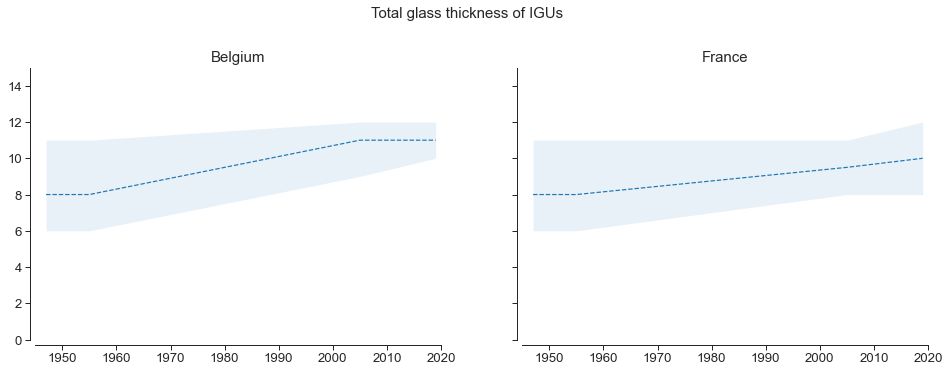

In [66]:
# Taking into acount uncertainty, with min. and max. average thickness:
# Plot evolution of total glass thickness of IGUs:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    sns.lineplot(data=df_be_fr_thick[('average thickness, mm', country)],
                 linestyle='--', ax=ax)

    ax.fill_between(df_be_fr_thick.index,
                    df_be_fr_thick[('max. thickness, mm', country)],
                    df_be_fr_thick[('min. thickness, mm', country)],
                    alpha=0.10)

    ax.set_title(country)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 15)

fig.suptitle('Total glass thickness of IGUs', fontsize=15, y=1.05)

sns.despine(offset=5)

## Post-Processing the Flows of IGUs

Estimation of missing date:
- Production = consumption + export - import

- Consumption = production + import - export

In [67]:
# Estimation of missing data according to units available:
# Production:
df_be_fr['Production'] = (
    df_be_fr['Production'].fillna(
        df_be_fr['Consumption']+df_be_fr['Export']-df_be_fr['Import']))

# Consumption:
df_be_fr['Consumption'] = (
    df_be_fr['Consumption'].fillna(
        df_be_fr['Production'] + df_be_fr['Import']-df_be_fr['Export']))

df_be_fr = df_be_fr.sort_index(axis=1)

In [68]:
# Stock raw data in a new Dataframe:
df_be_fr_init = df_be_fr

For Belgium, the data is either in m², tonnes or both. To "harmonise" the time series, the missing values are estimated from the average thickness of glass per IGU:

In [69]:
flows = ['Consumption', 'Production', 'Export', 'Import']

In [70]:
# Estimation of total flows per m² according to values in kt:
for flow in flows:
    # Conditions for calculating missing data according to units available:
    has_kt = df_be_fr[(f'{flow}', '[kt], average', 'Belgium')].notna()
    has_m2 = df_be_fr[(f'{flow}', '[10^6 m²]', 'Belgium')].notna()

    # Calculating missing values flows according to thickness:
    df_be_fr.loc[has_kt & ~has_m2, (
        f'{flow}', '[10^6 m²]', 'Belgium')] = (
        df_be_fr.loc[has_kt & ~has_m2, (
            f'{flow}', '[kt], average', 'Belgium')]
        / df_be_fr_thick[('average thickness, mm', 'Belgium')] / 2.5)

In [71]:
# Estimation of total flows per kt according to values in m²:
for flow in flows:
    # Conditions for calculating missing data according to units available:
    has_kt = df_be_fr[(f'{flow}', '[kt], average', 'Belgium')].notna()
    has_m2 = df_be_fr[(f'{flow}', '[10^6 m²]', 'Belgium')].notna()

    # Calculating flows if missing according to thickness:
    df_be_fr.loc[has_m2 & ~has_kt, (
        f'{flow}', '[kt], average', 'Belgium')] = (
        df_be_fr.loc[has_m2 & ~has_kt, (
            f'{flow}', '[10^6 m²]', 'Belgium')]
        * df_be_fr_thick[('average thickness, mm', 'Belgium')] * 2.5)

In [72]:
# Estimation of missing data according to units available:
# Production:
df_be_fr['Production'] = (
    df_be_fr['Production'].fillna(
        df_be_fr['Consumption']+df_be_fr['Export']-df_be_fr['Import']))

# Consumption:
df_be_fr['Consumption'] = (
    df_be_fr['Consumption'].fillna(
        df_be_fr['Production'] + df_be_fr['Import']-df_be_fr['Export']))

df_be_fr = df_be_fr.sort_index(axis=1)

Taking into acount uncertainties regarding total glass thickness of the IGUs in Belgium:

In [73]:
for flow in flows:
    for level in ["min.", "max."]:
        df_be_fr[(f'{flow}', f'[kt], {level}', 'Belgium')] = (
            df_be_fr[(f'{flow}', '[10^6 m²]', 'Belgium')]
            * df_be_fr_thick[(f'{level} thickness, mm', 'Belgium')] * 2.5)

df_be_fr = df_be_fr.sort_index(axis=1)

Weighing the flows of IGUs, France (i.e. from Mm² to kt).
<br>
And taking into account uncertainties regarding the total glass thickness of the IGUs:

In [74]:
# Estimating total weight of the flows of IGUs [kt], France (raw data in m²)
# to be used later for material/energy/carbon intensity
for flow in flows:
    for level in levels:
        df_be_fr[(f'{flow}', f'[kt], {level}', 'France')] = (
            df_be_fr[(f'{flow}', '[10^6 m²]', 'France')]
            * df_be_fr_thick[(f'{level} thickness, mm', 'France')] * 2.5)

df_be_fr = df_be_fr.sort_index(axis=1)

In [75]:
df_be_fr[20:40].style

## Production of Insulating Glass Units

Text(0.5, 1.1, 'IGU production [million m²/y]')

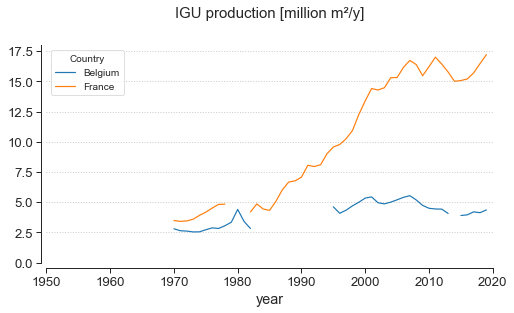

In [76]:
# Plot the BE and FR production of IGUs:
fig, ax = plt.subplots(figsize=(8, 4))

df_be_fr[('Production', '[10^6 m²]')].plot(ax=ax)
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 18)

sns.despine(offset=5)
ax.set_title('IGU production [million m²/y]', y=1.1)

Text(0.5, 1.1, 'IGU production [million m²/y]')

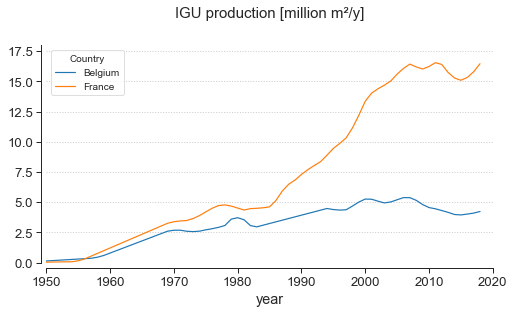

In [77]:
# Plot the moving average of the IGU production in BE and FR:
fig, ax = plt.subplots(figsize=(8, 4))

df_be_fr[('Production', '[10^6 m²]')].interpolate(
    method="linear", limit_area='inside').rolling(
    3, center=True).mean().plot(ax=ax)
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 18)

sns.despine(offset=5)
ax.set_title('IGU production [million m²/y]', y=1.1)

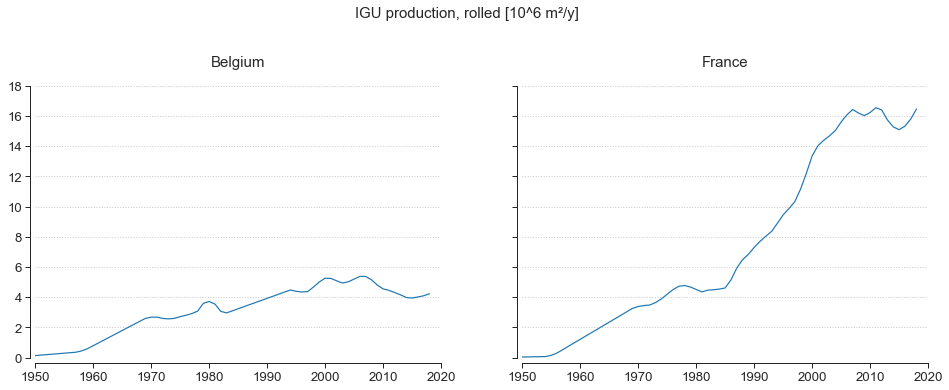

In [78]:
# Plot a moving average for IGU production:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(df_be_fr.index,
            df_be_fr[('Production', '[10^6 m²]')][country]
            # Linear interpolation for IGU production:
            .interpolate(method="linear", limit_area='inside')
            # Rolling IGU production according to a 3-year mean:
            .rolling(3, center=True).mean())

    ax.set_title(country, y=1.05)
    ax.set_xlim(1950, 2020)
    ax.set_ylim(0, 18)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

fig.suptitle('IGU production, rolled [10^6 m²/y]', fontsize=15, y=1.1)
sns.despine(offset=5)
plt.show()

## Consumption of Insulating Glass Units

Text(0.5, 1.1, 'Consumption of IGUs [million m²/y]')

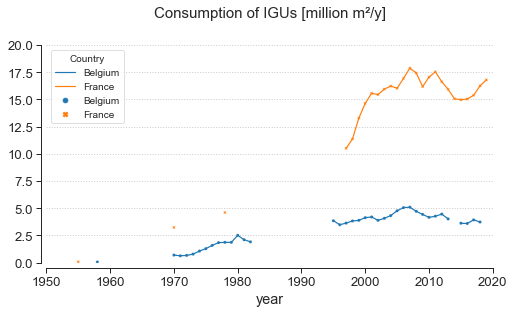

In [79]:
# Plot the BE and FR production of IGUs:
fig, ax = plt.subplots(figsize=(8, 4))

df_be_fr[('Consumption', '[10^6 m²]')].plot(ax=ax)
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

sns.scatterplot(data=df_be_fr['Consumption', '[10^6 m²]'],
                marker='.', s=10, color='grey',
                ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 20)

sns.despine(offset=5)
ax.set_title('Consumption of IGUs [million m²/y]', y=1.1)

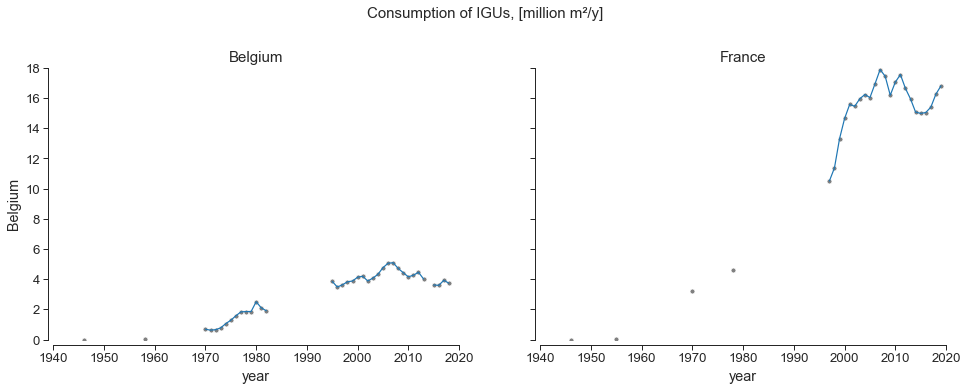

In [80]:
# Plot total consumption of IGU:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):

    ax.plot(df_be_fr.index,
            df_be_fr['Consumption', '[10^6 m²]'][country])
    ax.set_title(country)

    sns.scatterplot(data=df_be_fr['Consumption', '[10^6 m²]'][country],
                    marker='.', s=100, color='grey',
                    ax=ax)

ax.set_xlim(1940, 2020)
ax.set_ylim(0, 18)

fig.suptitle('Consumption of IGUs, [million m²/y]', fontsize=15, y=1.05)
sns.despine(offset=5)
plt.show()

Given the scarcity of data on the consumption of insulating glass units in France, and considering the low level of exports and imports over the study period, we assume that the production is roughly equivalent to the consumption when data is missing. Please refer to the article for a detailed discussion of this hypothesis.

In [81]:
# Estimation of missing data relating to the consumption of IGU:
for unit in ['[kt], average', '[kt], max.', '[kt], min.', '[10^6 m²]']:
    df_be_fr['Consumption', unit, 'France'] = (
        df_be_fr['Consumption', unit, 'France'].fillna(
            df_be_fr['Production', unit, 'France']))

Text(0.5, 1.1, 'Consumption of IGU, 3-y rolled [million m²/y]')

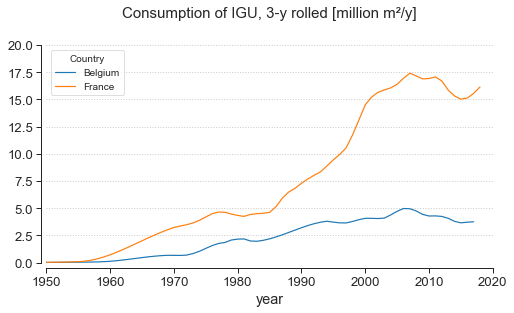

In [82]:
# Linear interpolation for IGU consumption
# and moving average with a 3-year window length:
fig, ax = plt.subplots(figsize=(8, 4))

(df_be_fr[('Consumption', '[10^6 m²]')]
 .interpolate(method="pchip", limit_area='inside')
 .rolling(3, center=True).mean().plot(ax=ax))

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 20)

sns.despine(offset=5)
ax.set_title('Consumption of IGU, 3-y rolled [million m²/y]', y=1.1)

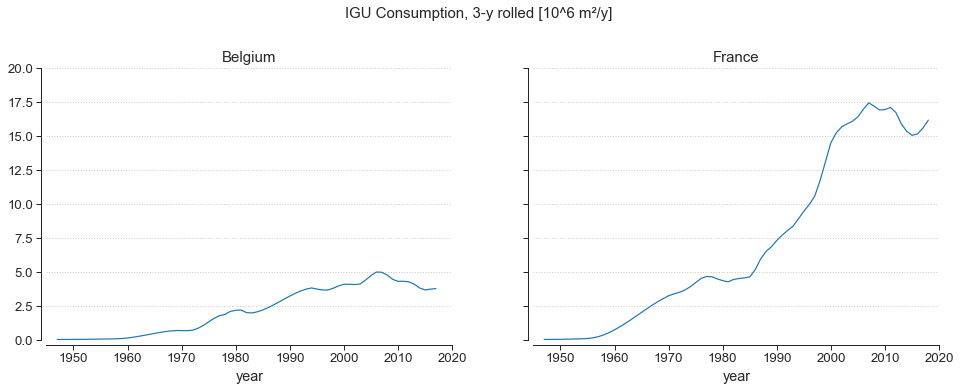

In [83]:
# Linear interpolation for IGU consumption
# and moving average with a 3-year window length:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    (df_be_fr['Consumption', '[10^6 m²]'][country]
     .interpolate(method="pchip", limit_area='inside')
     .rolling(3, center=True).mean()).plot(ax=ax)

    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    ax.set_title(country)

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 20)

fig.suptitle('IGU Consumption, 3-y rolled [10^6 m²/y]',
             fontsize=15, y=1.05)
sns.despine(offset=5)
plt.show()

Estimation of the consumption of IGU per capita in BE and FR:

In [84]:
# Estimating the IGU consumption per capita
for country in countries:
    df_be_fr[('Consumption', '[m²/cap]', country)] = (
        df_be_fr[('Consumption', '[10^6 m²]', country)]
        .interpolate(method='pchip', limit_area="inside")*1000
        / df_be_fr_pop[('Population [x1000]', country)]
        .interpolate(method='pchip', limit_area="inside"))

df_be_fr = df_be_fr.sort_index(axis=1)

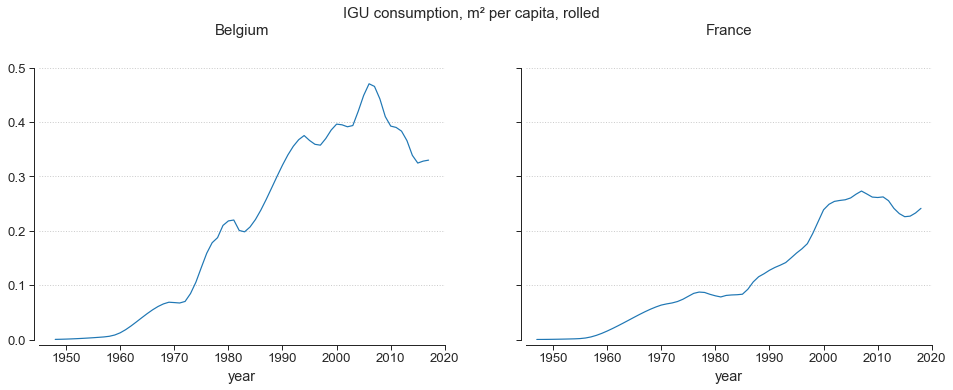

In [85]:
# Linear interpolation for IGU consumption per capita
# and moving average with a 3-y. window length:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    (df_be_fr['Consumption', '[m²/cap]'][country]
     .interpolate(method="pchip", limit_area='inside')
     .rolling(3, center=True).mean()).plot(ax=ax)

    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    ax.set_title(country, y=1.1)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 0.5)

fig.suptitle('IGU consumption, m² per capita, rolled',
             fontsize=15, y=1.05)
sns.despine(offset=5)
plt.show()

In [86]:
df_be_fr = df_be_fr.drop('[m²/cap]', axis=1, level=1)

## Summary

In [87]:
df_be_fr['Consumption'].describe()

Unit    [10^6 m²]        [kt], average         [kt], max.         [kt], min.  \
Country   Belgium France       Belgium  France    Belgium  France    Belgium   
count       38.00  49.00         37.00   48.00      37.00   48.00      37.00   
mean         2.99  10.11         81.52  243.50      91.16  290.15      67.74   
std          1.54   5.63         42.44  137.02      44.98  157.99      36.27   
min          0.00   0.00          1.02    1.29       1.38    1.77       0.77   
25%          1.83   4.60         43.38  103.04      53.00  130.77      34.13   
50%          3.67   9.56        100.01  222.67     111.72  265.80      83.67   
75%          4.14  15.93        112.72  380.86     124.47  443.71      96.45   
max          5.09  17.88        139.84  427.75     152.55  504.00     116.23   

Unit             
Country  France  
count     48.00  
mean     200.05  
std      114.01  
min        0.97  
25%       81.91  
50%      184.13  
75%      316.42  
max      357.52

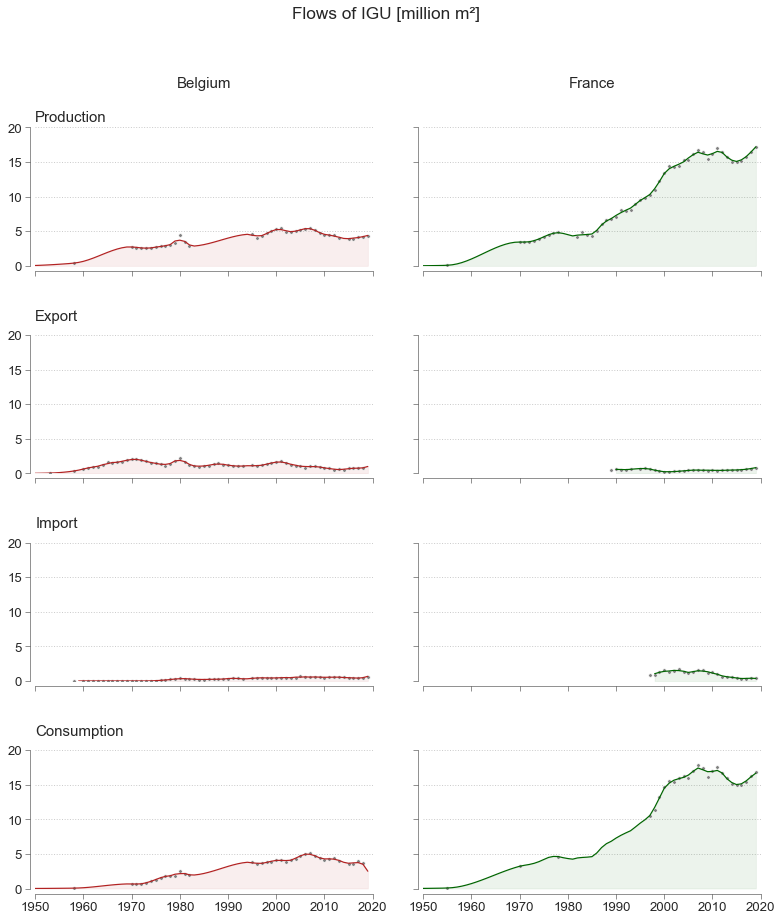

In [257]:
# Plot total flows, moving average w/ a 3-y. window length:
toplot = ['Production', 'Export', 'Import', 'Consumption']
nrows = len(toplot)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(13, 14))

for row, data in enumerate(toplot):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'firebrick'
            ax.set_title(f"{data}", loc='left', pad=15)
        else:
            color = 'darkgreen'

        (df_be_fr[(data, "[10^6 m²]", country)]
         .interpolate(method='pchip')
         .rolling(3, center=True).mean()
         .plot(ax=ax, c=color)
         )

        x = df_be_fr.index
        y = (df_be_fr[(data, "[10^6 m²]", country)]
             .interpolate(method='pchip')
             .rolling(3, center=True).mean())
        ax.fill_between(x, y, color=color, alpha=0.075)

        # Plot raw data:
        sns.scatterplot(data=df_be_fr_init[data, "[10^6 m²]"][country],
                        marker='.', s=50, color='grey',
                        ax=ax)

        ax.get_legend().remove()

        ax.minorticks_off()
        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)
        ax.set_ylabel(None)

        if row == 0:
            ax.set_title(country, y=1.25)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 20)
plt.xticks(np.arange(1950, 2021, 10))

fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle("Flows of IGU [million m²]", y=1)
sns.despine(offset=5)

plt.show()

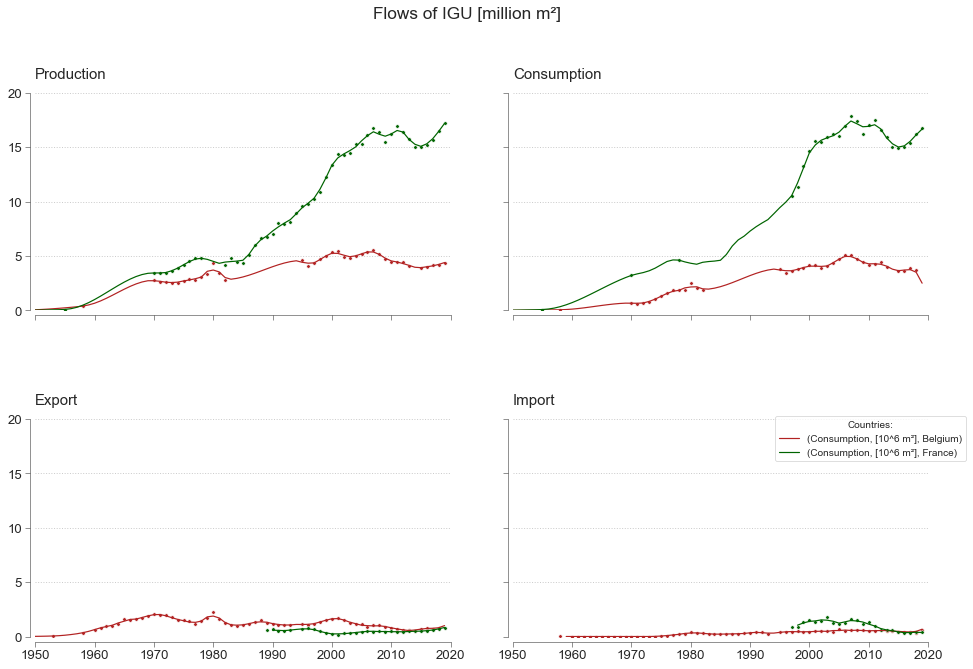

In [258]:
# Plot total flows, moving average w/ a 3-y. window length:
toplot = ['Production', 'Export', 'Import', 'Consumption']

fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 10))

for data in toplot:
    if data == "Production":
        ax = axes[0][0]
    if data == "Consumption":
        ax = axes[0][1]
    if data == "Export":
        ax = axes[1][0]
    if data == "Import":
        ax = axes[1][1]

    for country in countries:
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'firebrick'
            ax.set_title(f"{data}", loc='left', pad=15)
        else:
            color = 'darkgreen'

        (df_be_fr[(data, "[10^6 m²]", country)]
         .interpolate(method='pchip')
         .rolling(3, center=True).mean()
         .plot(ax=ax, c=color)
         )

        # Plot raw data:
        sns.scatterplot(data=df_be_fr_init[data, "[10^6 m²]", country],
                        marker='.', s=50, color=color,
                        ax=ax)

        ax.get_legend().remove()

        ax.minorticks_off()
        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)
        ax.set_ylabel(None)

        if row == 0:
            ax.set_title(country, y=1.25)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 20)
plt.yticks(np.arange(0, 21, 5))

fig.subplots_adjust(wspace=0.15, hspace=0.5)

# Add legend:
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center', ncol=1,
           title='Countries:',
           bbox_to_anchor=(0.85, 0.4))  # (0.83, 0.98)

fig.suptitle("Flows of IGU [million m²]", y=1)
sns.despine(offset=5)

plt.show()

# The European Production of IGU: Environmental Analysis

## Use of Raw Materials

In [90]:
# Absolute use of raw materials for IGU production:
for mat in materials:
    for level in levels:
        df_eu[(f"{mat}, production", f"[kt], {level}")] = (
            df_eu[('Production', f"[kt], {level}")]
            * (df_rawmat[(f"{mat}, kg/kg")]
               .interpolate(method='pchip', limit_direction='forward'))
        )

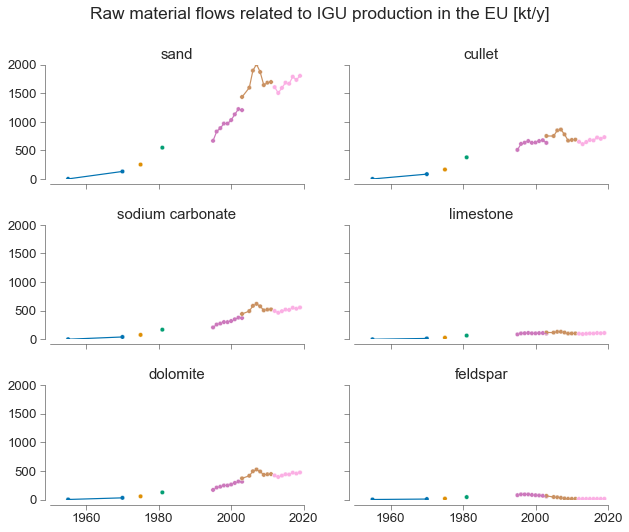

In [91]:
# Plot raw material flows for IGU production in the EU:
fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    sns.lineplot(data=df_eu[f"{mat}, production"].reset_index(),
                 x='year', y='[kt], average',
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)

    sns.scatterplot(data=df_eu[f"{mat}, production"].reset_index(),
                    x='year', y='[kt], average',
                    hue='Nbr of countries',
                    palette='colorblind', s=20,
                    ax=ax)

    ax.set_title(mat)
    ax.set_ylabel(None)
    style_ax(ax)
    ax.get_legend().remove()

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 2000)

fig.suptitle("Raw material flows related to IGU production in the EU [kt/y]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

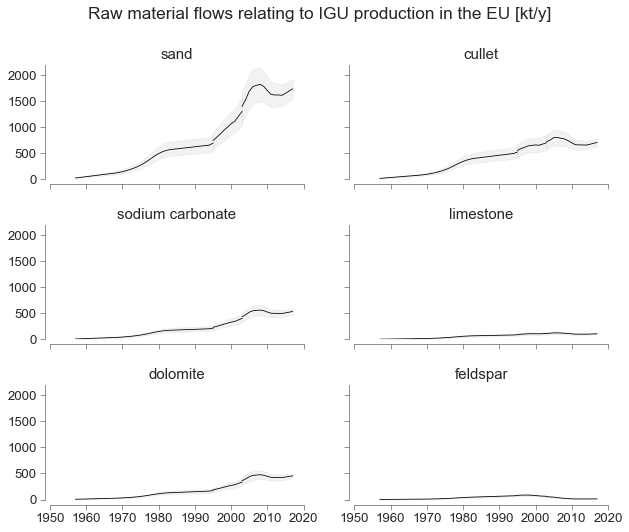

In [92]:
# Plot raw material flows for IGU production:
fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    for a, b in EU_COUNTRIES:
        ax.plot(df_eu.interpolate()
                .rolling(5, center=True).mean().loc[a:b]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [(f"{mat}, production", '[kt], average')],
                linewidth=0.8, c='black', linestyle='-'
                )

        ax.fill_between(df_eu.loc[a:b].reset_index(level='Nbr of countries')
                        .sort_values(by=['year']).index,
                        df_eu.interpolate().rolling(5, center=True).mean()
                        .loc[a:b].reset_index(level='Nbr of countries')
                        .sort_values(by=['year'])
                        [(f"{mat}, production", '[kt], max.')],
                        df_eu.interpolate().rolling(5, center=True).mean()
                        .loc[a:b].reset_index(level='Nbr of countries')
                        .sort_values(by=['year'])
                        [(f"{mat}, production", '[kt], min.')],
                        alpha=0.10, color='grey')

        ax.set_title(mat)
        style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 2200)
plt.yticks(np.arange(0, 2201, 500))

fig.suptitle("Raw material flows relating to IGU production in the EU [kt/y]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [93]:
# Estimate total use of raw materials (sum per material):
for level in levels:
    df_eu[('Total raw materials, production', f'[Mt], {level}')] = 0

for level in levels:
    for mat in materials:
        df_eu[('Total raw materials, production', f'[Mt], {level}')] = (
            df_eu[(f"{mat}, production", f'[kt], {level}')]/1000
            + df_eu[('Total raw materials, production', f'[Mt], {level}')]
        )

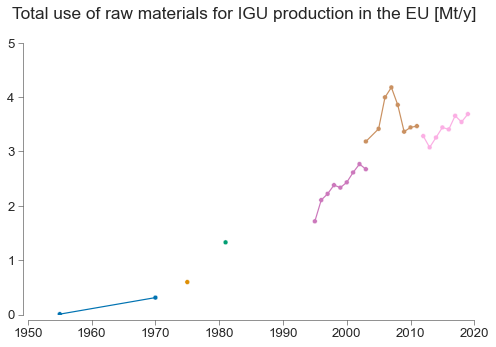

In [94]:
# Plot total material use for IGU production in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df_eu['Total raw materials, production'].reset_index(),
             x='year', y='[Mt], average',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

sns.scatterplot(data=df_eu['Total raw materials, production'].reset_index(),
                x='year', y='[Mt], average',
                hue='Nbr of countries',
                palette='colorblind',
                ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 5)
ax.set_ylabel(None)
style_ax(ax)
ax.get_legend().remove()

fig.suptitle("Total use of raw materials for IGU production in the EU [Mt/y]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

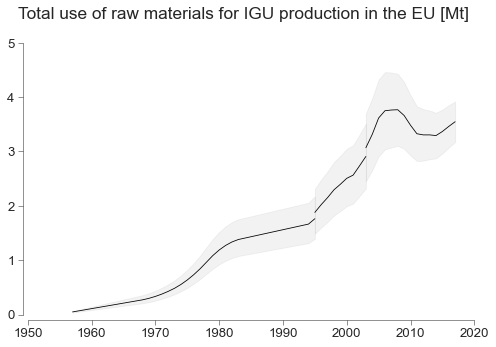

In [95]:
# Plot total material use for IGU production in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

for a, b in EU_COUNTRIES:
    ax.plot(df_eu.interpolate().rolling(5, center=True).mean()
            .loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('Total raw materials, production', '[Mt], average')],
            linewidth=0.8, c='black', linestyle='-'
            )

    ax.fill_between(df_eu.loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year']).index,
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [('Total raw materials, production', '[Mt], max.')],
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [('Total raw materials, production', '[Mt], min.')],
                    alpha=0.10, color='grey')

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 5)
style_ax(ax)

fig.suptitle("Total use of raw materials for IGU production in the EU [Mt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Energy Use

In [96]:
# Absolute use of energy for IGU production:
for energy in energies:
    for level in levels:
        df_eu[(f"{energy}, production", f"[PJ], {level}")] = (
            df_eu[('Production', f"[kt], {level}")]
            * (df_eu_energy[f"{energy}, GJ/t"]
               .interpolate(method='pchip', limit_direction='forward'))/1000
        )

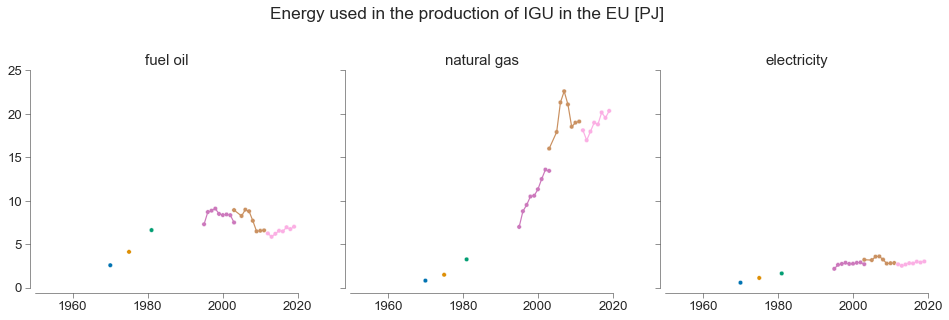

In [97]:
# Plot energy used for IGU production in EU:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    sns.lineplot(data=df_eu[f"{energy}, production"].reset_index(),
                 x='year', y='[PJ], average',
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)

    sns.scatterplot(data=df_eu[f"{energy}, production"].reset_index(),
                    x='year', y='[PJ], average',
                    hue='Nbr of countries',
                    palette='colorblind', s=20,
                    ax=ax)

    ax.set_title(energy)
    ax.set_ylabel(None)
    style_ax(ax)
    ax.get_legend().remove()

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 25)

fig.suptitle("Energy used in the production of IGU in the EU [PJ]", y=1.1)
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

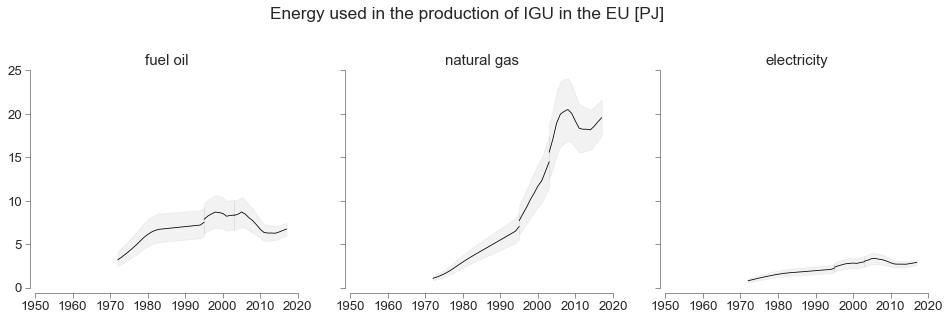

In [98]:
# Plot energy flows for IGU production, 5-y rolled:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    for a, b in EU_COUNTRIES:
        ax.plot(df_eu.interpolate()
                .rolling(5, center=True).mean().loc[a:b]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [(f"{energy}, production", '[PJ], average')],
                linewidth=0.8, c='black', linestyle='-'
                )

        ax.fill_between(df_eu.loc[a:b].reset_index(level='Nbr of countries')
                        .sort_values(by=['year']).index,
                        df_eu.interpolate().rolling(5, center=True).mean()
                        .loc[a:b].reset_index(level='Nbr of countries')
                        .sort_values(by=['year'])
                        [(f"{energy}, production", '[PJ], max.')],
                        df_eu.interpolate().rolling(5, center=True).mean()
                        .loc[a:b].reset_index(level='Nbr of countries')
                        .sort_values(by=['year'])
                        [(f"{energy}, production", '[PJ], min.')],
                        alpha=0.10, color='grey')

        ax.set_title(energy)
        style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 25)
plt.yticks(np.arange(0, 26, 5))

fig.suptitle("Energy used in the production of IGU in the EU [PJ]", y=1.1)
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [99]:
# Estimate total energy use (sum per energy type):
for level in levels:
    df_eu[('Total energy, production', f'[PJ], {level}')] = 0

for level in levels:
    for energy in energies:
        df_eu[('Total energy, production', f'[PJ], {level}')] = (
            df_eu[(f"{energy}, production", f'[PJ], {level}')]
            + df_eu[('Total energy, production', f'[PJ], {level}')]
        )

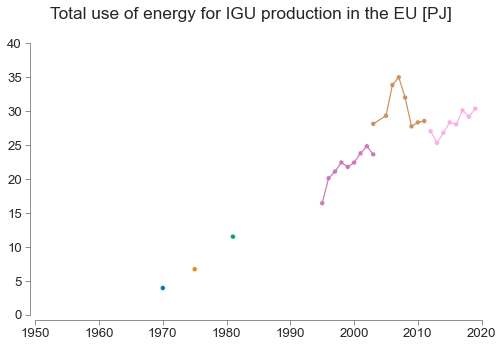

In [100]:
# Plot total energy use for IGU production in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df_eu['Total energy, production'].reset_index(),
             x='year', y='[PJ], average',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

sns.scatterplot(data=df_eu['Total energy, production'].reset_index(),
                x='year', y='[PJ], average',
                hue='Nbr of countries',
                palette='colorblind',
                ax=ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 40)
ax.get_legend().remove()
ax.set_ylabel(None)
style_ax(ax)

fig.suptitle("Total use of energy for IGU production in the EU [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

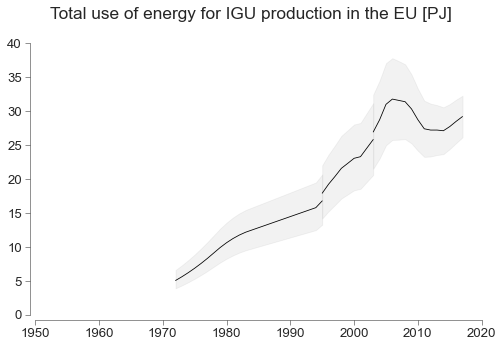

In [101]:
# Plot total energy use for IGU production in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

for a, b in EU_COUNTRIES:
    ax.plot(df_eu.interpolate().rolling(5, center=True).mean()
            .loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('Total energy, production', '[PJ], average')],
            linewidth=0.8, c='black', linestyle='-'
            )

    ax.fill_between(df_eu.loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year']).index,
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [('Total energy, production', '[PJ], max.')],
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [('Total energy, production', '[PJ], min.')],
                    alpha=0.10, color='grey')

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 40)
style_ax(ax)

fig.suptitle("Total use of energy for IGU production in the EU [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Absolute CO2 Emissions

In [102]:
# Estimating the co2 emission related to IGU production:
for level in levels:
    df_eu[("co2, production", f"[kt], {level}")] = (
        df_eu[('Production', f"[kt], {level}")]
        * df_eu_co2['CO2 interpolated [kg/t]'] / 1000
    )

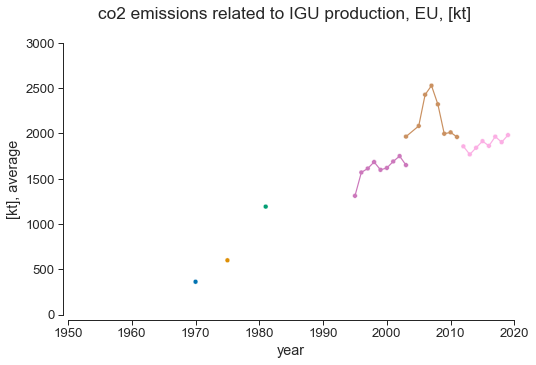

In [103]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df_eu['co2, production'].reset_index(),
             x='year', y='[kt], average',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

sns.scatterplot(data=df_eu['co2, production'].reset_index(),
                x='year', y='[kt], average',
                hue='Nbr of countries',
                palette='colorblind',
                ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 3000)
ax.get_legend().remove()

fig.suptitle("co2 emissions related to IGU production, EU, [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

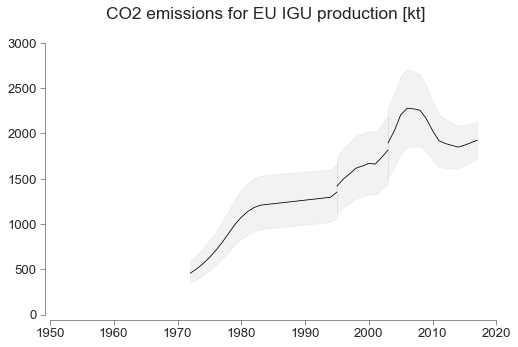

In [104]:
# Plot total co2 emissions for IGU production in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

for a, b in EU_COUNTRIES:
    ax.plot(df_eu.interpolate().rolling(5, center=True).mean()
            .loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('co2, production', '[kt], average')],
            linewidth=0.8, c='black', linestyle='-'
            )

    ax.fill_between(df_eu.loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year']).index,
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [('co2, production', '[kt], max.')],
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [('co2, production', '[kt], min.')],
                    alpha=0.10, color='grey')

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 3000)
style_ax(ax)

fig.suptitle("CO2 emissions for EU IGU production [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

# The European Consumption of IGU: Environmental Analysis

## Use of Raw Materials

In [105]:
# Absolute use of raw materials for IGU consumption:
for mat in materials:
    for level in levels:
        df_eu[(f"{mat}, consumption", f"[kt], {level}")] = (
            df_eu[('Estimated consumption', f"[kt], {level}")]
            * (df_rawmat[(f"{mat}, kg/kg")]
               .interpolate(method='pchip', limit_direction='forward'))
        )

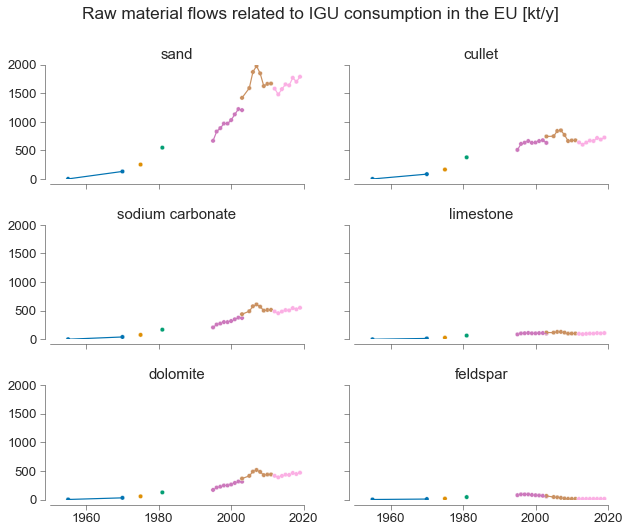

In [106]:
# Plot raw material flows for IGU consumption in the EU:
fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    sns.lineplot(data=df_eu[f"{mat}, consumption"].reset_index(),
                 x='year', y='[kt], average',
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)

    sns.scatterplot(data=df_eu[f"{mat}, consumption"].reset_index(),
                    x='year', y='[kt], average',
                    hue='Nbr of countries',
                    palette='colorblind', s=20,
                    ax=ax)

    ax.set_title(mat)
    ax.set_ylabel(None)
    style_ax(ax)
    ax.get_legend().remove()

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 2000)

fig.suptitle("Raw material flows related to IGU consumption in the EU [kt/y]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

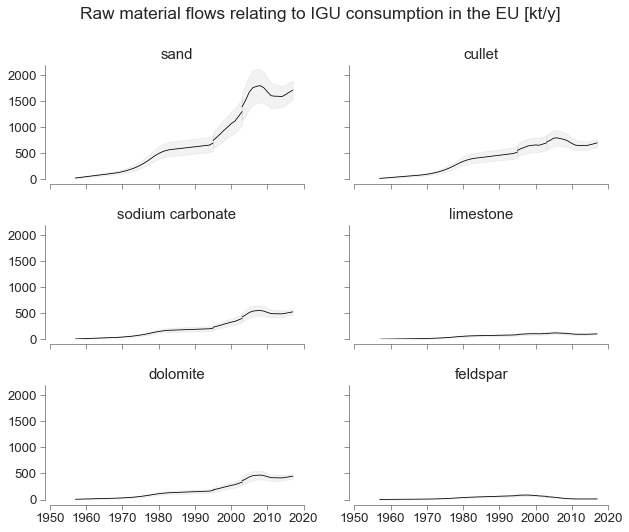

In [107]:
# Plot raw material flows for IGU consumption:
fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    for a, b in EU_COUNTRIES:
        ax.plot(df_eu.interpolate()
                .rolling(5, center=True).mean().loc[a:b]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [(f"{mat}, consumption", '[kt], average')],
                linewidth=0.8, c='black', linestyle='-'
                )

        ax.fill_between(df_eu.loc[a:b].reset_index(level='Nbr of countries')
                        .sort_values(by=['year']).index,
                        df_eu.interpolate().rolling(5, center=True).mean()
                        .loc[a:b].reset_index(level='Nbr of countries')
                        .sort_values(by=['year'])
                        [(f"{mat}, consumption", '[kt], max.')],
                        df_eu.interpolate().rolling(5, center=True).mean()
                        .loc[a:b].reset_index(level='Nbr of countries')
                        .sort_values(by=['year'])
                        [(f"{mat}, consumption", '[kt], min.')],
                        alpha=0.10, color='grey')

        ax.set_title(mat)
        style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 2200)
plt.yticks(np.arange(0, 2201, 500))

fig.suptitle("Raw material flows relating to IGU consumption in the EU [kt/y]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [108]:
# Estimate total use of raw materials (sum per material):
for level in levels:
    df_eu[('Total raw materials, consumption', f'[Mt], {level}')] = 0

for level in levels:
    for mat in materials:
        df_eu[('Total raw materials, consumption', f'[Mt], {level}')] = (
            df_eu[(f"{mat}, consumption", f'[kt], {level}')]/1000
            + df_eu[('Total raw materials, consumption', f'[Mt], {level}')]
        )

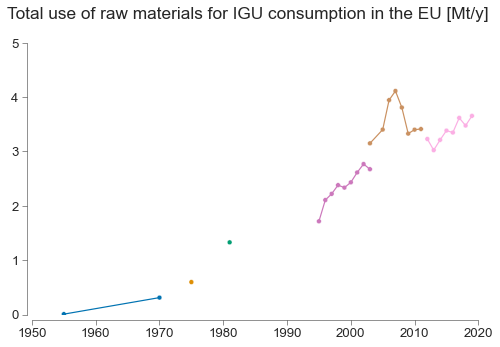

In [109]:
# Plot total material use for IGU consumption in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df_eu['Total raw materials, consumption'].reset_index(),
             x='year', y='[Mt], average',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

sns.scatterplot(data=df_eu['Total raw materials, consumption'].reset_index(),
                x='year', y='[Mt], average',
                hue='Nbr of countries',
                palette='colorblind',
                ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 5)
ax.set_ylabel(None)
style_ax(ax)
ax.get_legend().remove()

fig.suptitle("Total use of raw materials for IGU consumption in the EU [Mt/y]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

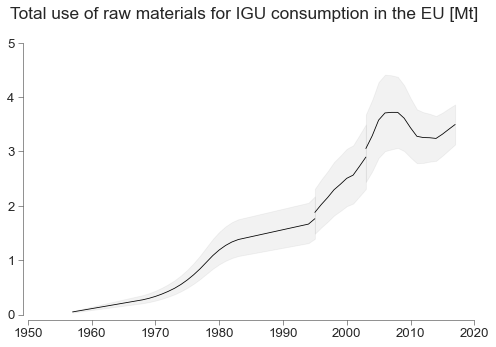

In [110]:
# Plot total material use for IGU consumption in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

for a, b in EU_COUNTRIES:
    ax.plot(df_eu.interpolate().rolling(5, center=True).mean()
            .loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('Total raw materials, consumption', '[Mt], average')],
            linewidth=0.8, c='black', linestyle='-'
            )

    ax.fill_between(df_eu.loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year']).index,
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [('Total raw materials, consumption', '[Mt], max.')],
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [('Total raw materials, consumption', '[Mt], min.')],
                    alpha=0.10, color='grey')

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 5)
style_ax(ax)

fig.suptitle("Total use of raw materials for IGU consumption in the EU [Mt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Energy Use

In [111]:
# Absolute use of energy for IGU consumption:
for energy in energies:
    for level in levels:
        df_eu[(f"{energy}, consumption", f"[PJ], {level}")] = (
            df_eu[('Estimated consumption', f"[kt], {level}")]
            * (df_eu_energy[f"{energy}, GJ/t"]
               .interpolate(method='pchip', limit_direction='forward'))/1000
        )

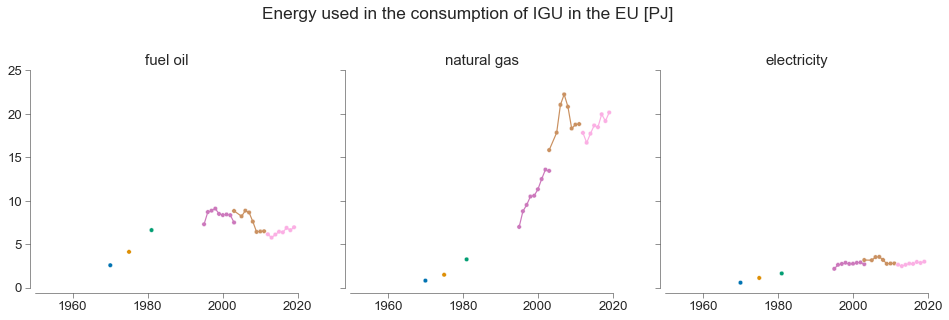

In [112]:
# Plot energy used for IGU consumption in EU:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    sns.lineplot(data=df_eu[f"{energy}, consumption"].reset_index(),
                 x='year', y='[PJ], average',
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)

    sns.scatterplot(data=df_eu[f"{energy}, consumption"].reset_index(),
                    x='year', y='[PJ], average',
                    hue='Nbr of countries',
                    palette='colorblind', s=20,
                    ax=ax)

    ax.set_title(energy)
    ax.set_ylabel(None)
    style_ax(ax)
    ax.get_legend().remove()

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 25)

fig.suptitle("Energy used in the consumption of IGU in the EU [PJ]", y=1.1)
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

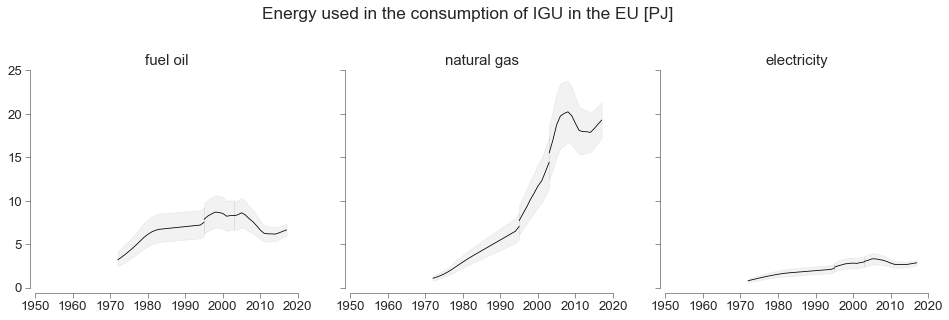

In [113]:
# Plot energy flows for IGU consumption, 5-y rolled:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    for a, b in EU_COUNTRIES:
        ax.plot(df_eu.interpolate()
                .rolling(5, center=True).mean().loc[a:b]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [(f"{energy}, consumption", '[PJ], average')],
                linewidth=0.8, c='black', linestyle='-'
                )

        ax.fill_between(df_eu.loc[a:b].reset_index(level='Nbr of countries')
                        .sort_values(by=['year']).index,
                        df_eu.interpolate().rolling(5, center=True).mean()
                        .loc[a:b].reset_index(level='Nbr of countries')
                        .sort_values(by=['year'])
                        [(f"{energy}, consumption", '[PJ], max.')],
                        df_eu.interpolate().rolling(5, center=True).mean()
                        .loc[a:b].reset_index(level='Nbr of countries')
                        .sort_values(by=['year'])
                        [(f"{energy}, consumption", '[PJ], min.')],
                        alpha=0.10, color='grey')

        ax.set_title(energy)
        style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 25)
plt.yticks(np.arange(0, 26, 5))

fig.suptitle("Energy used in the consumption of IGU in the EU [PJ]", y=1.1)
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [114]:
# Estimate total energy use (sum per energy type):
for level in levels:
    df_eu[('Total energy, consumption', f'[PJ], {level}')] = 0

for level in levels:
    for energy in energies:
        df_eu[('Total energy, consumption', f'[PJ], {level}')] = (
            df_eu[(f"{energy}, consumption", f'[PJ], {level}')]
            + df_eu[('Total energy, consumption', f'[PJ], {level}')]
        )

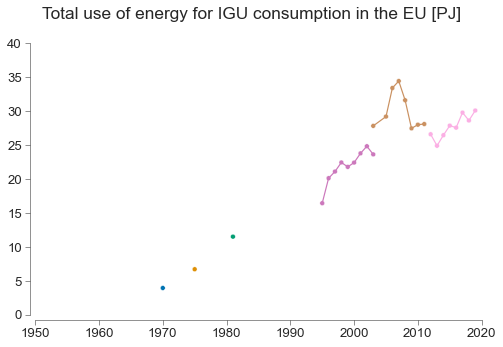

In [115]:
# Plot total energy use for IGU consumption in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df_eu['Total energy, consumption'].reset_index(),
             x='year', y='[PJ], average',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

sns.scatterplot(data=df_eu['Total energy, consumption'].reset_index(),
                x='year', y='[PJ], average',
                hue='Nbr of countries',
                palette='colorblind',
                ax=ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 40)
ax.get_legend().remove()
ax.set_ylabel(None)
style_ax(ax)

fig.suptitle("Total use of energy for IGU consumption in the EU [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

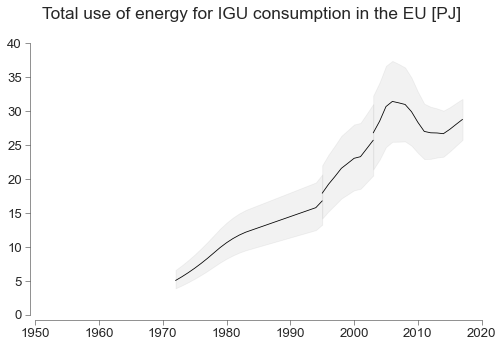

In [116]:
# Plot total energy use for IGU consumption in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

for a, b in EU_COUNTRIES:
    ax.plot(df_eu.interpolate().rolling(5, center=True).mean()
            .loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('Total energy, consumption', '[PJ], average')],
            linewidth=0.8, c='black', linestyle='-'
            )

    ax.fill_between(df_eu.loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year']).index,
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [('Total energy, consumption', '[PJ], max.')],
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [('Total energy, consumption', '[PJ], min.')],
                    alpha=0.10, color='grey')

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 40)
style_ax(ax)

fig.suptitle("Total use of energy for IGU consumption in the EU [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Absolute CO2 Emissions

In [117]:
# Estimating the co2 emission related to IGU consumption:
for level in levels:
    df_eu[("co2, consumption", f"[kt], {level}")] = (
        df_eu[('Estimated consumption', f"[kt], {level}")]
        * df_eu_co2['CO2 interpolated [kg/t]'] / 1000
    )

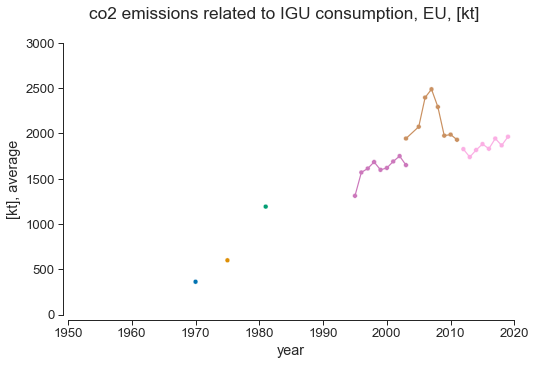

In [118]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df_eu['co2, consumption'].reset_index(),
             x='year', y='[kt], average',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

sns.scatterplot(data=df_eu['co2, consumption'].reset_index(),
                x='year', y='[kt], average',
                hue='Nbr of countries',
                palette='colorblind',
                ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 3000)
ax.get_legend().remove()

fig.suptitle("co2 emissions related to IGU consumption, EU, [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

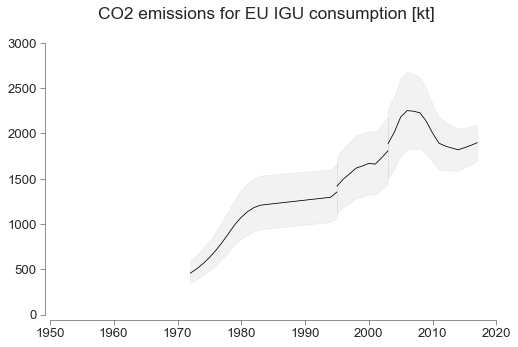

In [119]:
# Plot total co2 emissions for IGU consumption in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

for a, b in EU_COUNTRIES:
    ax.plot(df_eu.interpolate().rolling(5, center=True).mean()
            .loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('co2, consumption', '[kt], average')],
            linewidth=0.8, c='black', linestyle='-'
            )

    ax.fill_between(df_eu.loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year']).index,
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [('co2, consumption', '[kt], max.')],
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [('co2, consumption', '[kt], min.')],
                    alpha=0.10, color='grey')

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 3000)
style_ax(ax)

fig.suptitle("CO2 emissions for EU IGU consumption [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Summary

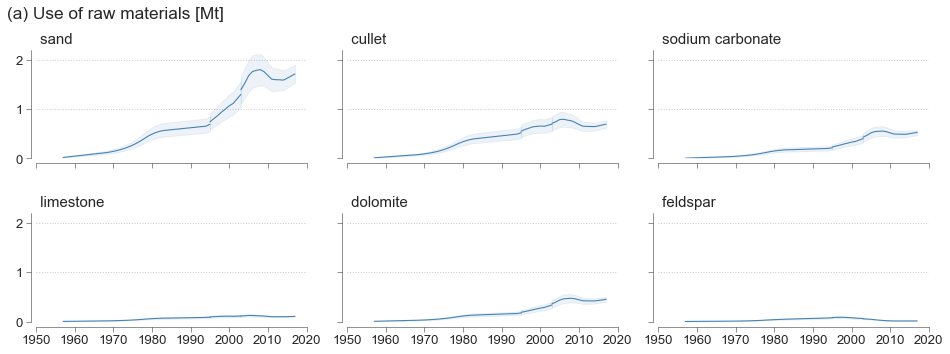

In [120]:
# Plot the absolute use of raw materials for IGU consumption in the EU:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    for a, b in EU_COUNTRIES:
        ax.plot(df_eu.interpolate().rolling(5, center=True).mean().loc[a:b]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [f"{mat}, consumption", '[kt], average'],
                linewidth=1.1, c='steelblue', linestyle='-')

        ax.fill_between(df_eu.loc[a:b].reset_index(level='Nbr of countries')
                        .sort_values(by=['year']).index,
                        df_eu.interpolate().rolling(5, center=True).mean()
                        .loc[a:b].reset_index(level='Nbr of countries')
                        .sort_values(by=['year'])
                        [(f"{mat}, consumption", '[kt], max.')],
                        df_eu.interpolate().rolling(5, center=True).mean()
                        .loc[a:b].reset_index(level='Nbr of countries')
                        .sort_values(by=['year'])
                        [(f"{mat}, consumption", '[kt], min.')],
                        alpha=0.10, color='steelblue')

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

    ax.set_title(f" {mat}", loc='left')
    style_ax(ax)

ax.set_ylim(0, 2200)
ax.set_xlim(1950, 2020)
plt.yticks(np.arange(0, 2201, 1000))
plt.xticks(np.arange(1950, 2021, 10))

# Divide by 1000 the y-axis, results in Mt:
ax.yaxis.set_major_formatter(y_1000)

# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# Why I can't divide by 1000 and add a decimal?

fig.suptitle("(a) Use of raw materials [Mt]", x=0.1, y=1, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.5)

sns.despine(offset=5)
plt.show()

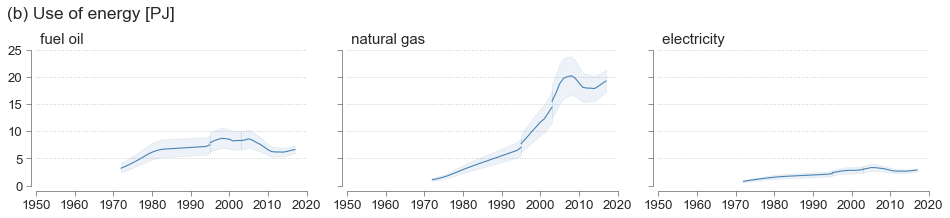

In [121]:
# Plot the absolute use of energy in the EU for IGU consumption:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 2.5))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    for a, b in EU_COUNTRIES:
        ax.plot(df_eu.interpolate().rolling(5, center=True).mean().loc[a:b]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [(f"{energy}, consumption", '[PJ], average')],
                linewidth=1.1, c='steelblue', linestyle='-')

        ax.fill_between(df_eu.loc[a:b].reset_index(level='Nbr of countries')
                        .sort_values(by=['year']).index,
                        df_eu.interpolate().rolling(5, center=True).mean()
                        .loc[a:b].reset_index(level='Nbr of countries')
                        .sort_values(by=['year'])
                        [(f"{energy}, consumption", '[PJ], max.')],
                        df_eu.interpolate().rolling(5, center=True).mean()
                        .loc[a:b].reset_index(level='Nbr of countries')
                        .sort_values(by=['year'])
                        [(f"{energy}, consumption", '[PJ], min.')],
                        alpha=0.10, color='steelblue')

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

    ax.set_title(f" {energy}", loc='left')
    style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 25)
plt.xticks(np.arange(1950, 2021, 10))

fig.suptitle("(b) Use of energy [PJ]", x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.15)

sns.despine(offset=5)
plt.show()

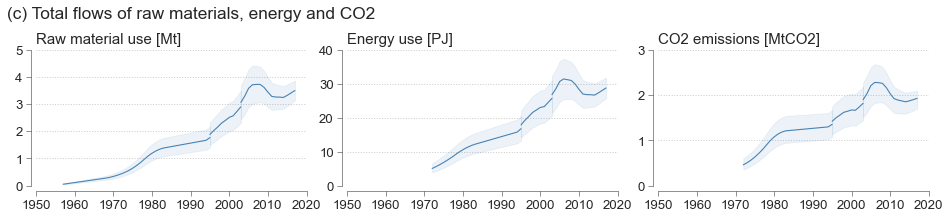

In [122]:
# Plot total energy & material use, total CO2 emissions for IGU consumption:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True,
                         figsize=(16, 2.5))

# Total use of raw materials:
ax = axes[0]
for a, b in EU_COUNTRIES:
    ax.plot(df_eu.interpolate().rolling(5, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('Total raw materials, consumption', '[Mt], average')],
            linewidth=1.1, c='steelblue', linestyle='-')

    ax.fill_between(df_eu.loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year']).index,
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [("Total raw materials, consumption", '[Mt], max.')],
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [("Total raw materials, consumption", '[Mt], min.')],
                    alpha=0.10, color='steelblue')

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_title("Raw material use [Mt]", loc='left')
style_ax(ax)
ax.set_ylim(0, 5)
ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))

# Total use of energy:
ax = axes[1]
for a, b in EU_COUNTRIES:
    ax.plot(df_eu.interpolate().rolling(5, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('Total energy, consumption', '[PJ], average')],
            linewidth=1.1, c='steelblue', linestyle='-')

    ax.fill_between(df_eu.loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year']).index,
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [("Total energy, consumption", '[PJ], max.')],
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [("Total energy, consumption", '[PJ], min.')],
                    alpha=0.10, color='steelblue')

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_title("Energy use [PJ]", loc='left')
style_ax(ax)
ax.set_ylim(0, 40)

# Total emissions of CO2:
ax = axes[2]
for a, b in EU_COUNTRIES:
    ax.plot(df_eu.interpolate().rolling(5, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('co2, production', '[kt], average')],
            linewidth=1.1, c='steelblue', linestyle='-')

    ax.fill_between(df_eu.loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year']).index,
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [('co2, consumption', '[kt], max.')],
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [('co2, consumption', '[kt], min.')],
                    alpha=0.10, color='steelblue')

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

# Divide by 1000 the y-axis, results in Mt
ax.yaxis.set_major_formatter(y_1000)

ax.set_title("CO2 emissions [MtCO2]", loc='left')
style_ax(ax)
ax.set_ylim(0, 3000)

fig.suptitle("(c) Total flows of raw materials, energy and CO2",
             x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.15)

sns.despine(offset=5)
plt.show()

# The Belgian and French Production of IGU: Environmental Analysis

## Raw Material Flows

In [123]:
print("List of materials:", materials)
print("Levels are:", levels)

List of materials: ['sand', 'cullet', 'sodium carbonate', 'limestone', 'dolomite', 'feldspar']
Levels are: ['average', 'min.', 'max.']


In [124]:
# Absolute use of raw materials for IGU production:
for mat in materials:
    for level in levels:
        for country in countries:
            df_be_fr[(f"{mat}, production", f"[kt], {level}", country)] = (
                df_be_fr[('Production', f"[kt], {level}", country)]
                * (df_rawmat[(f"{mat}, kg/kg")]
                   .interpolate(method='pchip', limit_direction='forward'))
            )

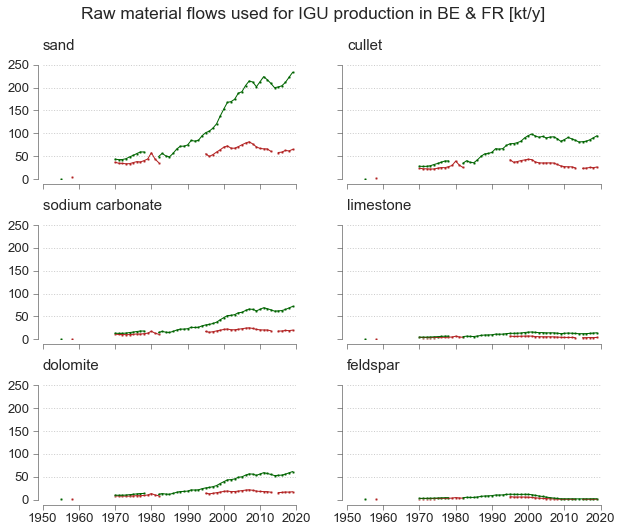

In [125]:
# Plot raw material flows for IGU production:
fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    for country in countries:
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'firebrick'
            ax.set_title(f"{mat}", loc='left', pad=15)
        else:
            color = 'darkgreen'

        ax.plot(df_be_fr[(f"{mat}, production", '[kt], average', country)],
                linewidth=1, c=color
                )

        sns.scatterplot(data=df_be_fr[(f"{mat}, production",
                                       '[kt], average', country)],
                        color=color, ax=ax, marker='.', s=30
                        )

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        ax.yaxis.label.set_visible(False)
        style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 250)
plt.yticks(np.arange(0, 251, 50))

fig.suptitle("Raw material flows used for IGU production in BE & FR [kt/y]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

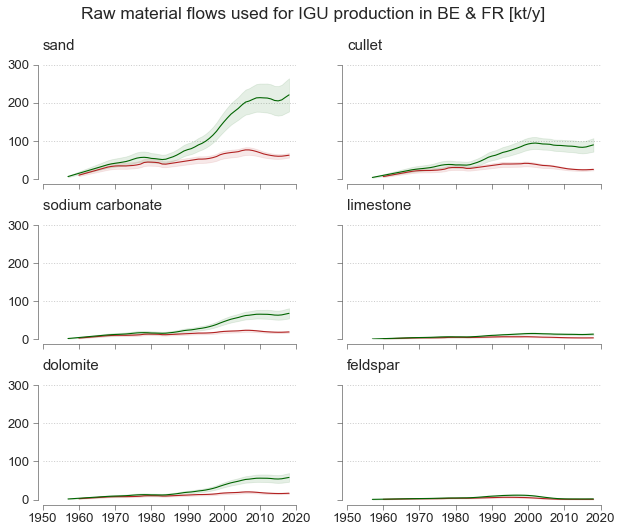

In [126]:
# Plot raw material flows for IGU production:
fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    for country in countries:
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'firebrick'
            ax.set_title(f"{mat}", loc='left', pad=15)
        else:
            color = 'darkgreen'

        ax.plot(df_be_fr.interpolate().rolling(5, center=True).mean()
                [(f"{mat}, production", '[kt], average', country)],
                linewidth=1.1, c=color
                )

        ax.fill_between(df_be_fr.index,
                        df_be_fr.interpolate().rolling(5, center=True).mean()
                        [(f"{mat}, production", '[kt], max.', country)],
                        df_be_fr.interpolate().rolling(5, center=True).mean()
                        [(f"{mat}, production", '[kt], min.', country)],
                        alpha=0.10, color=color)

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 300)
plt.yticks(np.arange(0, 301, 100))

fig.suptitle("Raw material flows used for IGU production in BE & FR [kt/y]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [127]:
# Estimate total use of raw materials (sum per material):
for level in levels:
    for country in countries:
        df_be_fr[('Total raw materials, production',
                  f'[kt], {level}', country)] = 0

for mat in materials:
    for level in levels:
        for country in countries:
            df_be_fr[('Total raw materials, production',
                      f'[kt], {level}', country)] = (
                df_be_fr[(f"{mat}, production",
                          f'[kt], {level}', country)]
                + df_be_fr[('Total raw materials, production',
                            f'[kt], {level}', country)]
            )

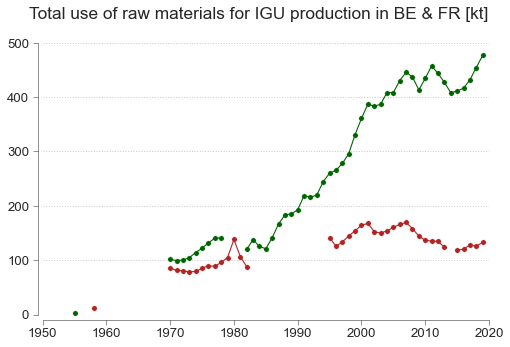

In [128]:
# Plot total material use for IGU production in Belgium and France:
fig, ax = plt.subplots(figsize=(8, 5))

for country in countries:
    # Define the color:
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'darkgreen'

    ax.plot(df_be_fr[('Total raw materials, production',
                      '[kt], average', country)],
            linewidth=1.1, c=color, linestyle='-'
            )

    sns.scatterplot(data=df_be_fr[('Total raw materials, production',
                              '[kt], average', country)],
                    color=color, s=30
                    )
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    ax.yaxis.label.set_visible(False)
    
ax.set_xlim(1950, 2020)
ax.set_ylim(0, 500)
style_ax(ax)

fig.suptitle("Total use of raw materials for IGU production in BE & FR [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

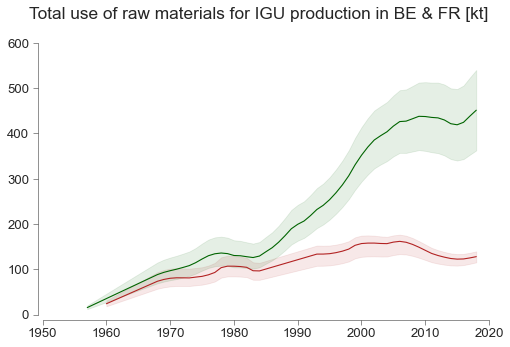

In [129]:
# Plot total material use for IGU production in Belgium and France:
fig, ax = plt.subplots(figsize=(8, 5))

for country in countries:
    # Define the color:
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'darkgreen'

    ax.plot(df_be_fr.interpolate().rolling(5, center=True).mean()
            [('Total raw materials, production', '[kt], average', country)],
            linewidth=1.1, c=color
            )

    ax.fill_between(df_be_fr.index,
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('Total raw materials, production',
                      '[kt], max.', country)],
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('Total raw materials, production',
                      '[kt], min.', country)],
                    alpha=0.10, color=color)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 600)
style_ax(ax)

fig.suptitle("Total use of raw materials for IGU production in BE & FR [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Energy Use

In [130]:
# Absolute use of energy for IGU production:
for energy in energies:
    for level in levels:
        for country in countries:
            df_be_fr[(f"{energy}, production", f"[PJ], {level}", country)] = (
                df_be_fr[('Production', f"[kt], {level}", country)]/1000
                * (df_be_fr_energy[(f"{energy}, GJ/t", country)]
                   .interpolate(method='pchip', limit_direction='forward'))
            )

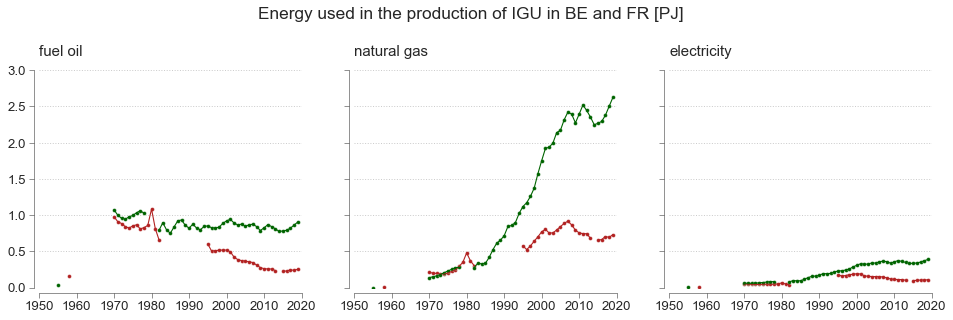

In [131]:
# Plot energy flows for IGU production:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    for country in countries:
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'firebrick'
            ax.set_title(f"{energy}", loc='left', pad=15)
        else:
            color = 'darkgreen'

        ax.plot(df_be_fr[(f"{energy}, production", '[PJ], average', country)],
                linewidth=1.1, c=color
                )

        sns.scatterplot(data=df_be_fr[(f"{energy}, production", 
                                  '[PJ], average', country)],
                color=color, ax=ax, s=15)
        
        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        ax.yaxis.label.set_visible(False)
        style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 3)
plt.yticks(np.arange(0, 3.1, 0.5))

fig.suptitle("Energy used in the production of IGU in BE and FR [PJ]", y=1.1)
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

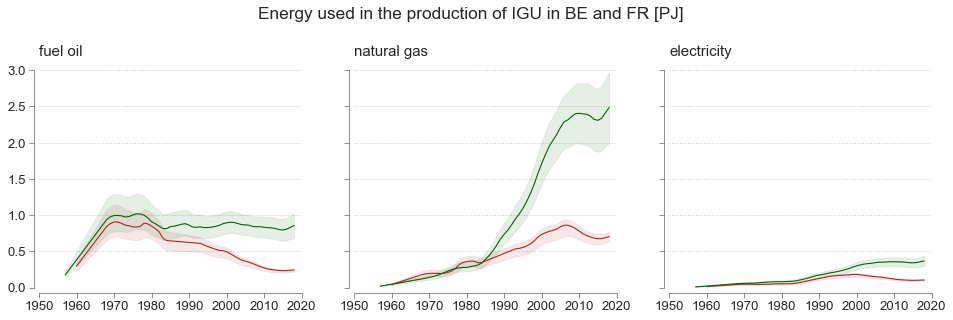

In [132]:
# Plot energy flows for IGU production:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    for country in countries:
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'firebrick'
            ax.set_title(f"{energy}", loc='left', pad=15)
        else:
            color = 'darkgreen'

        ax.plot(df_be_fr.interpolate().rolling(5, center=True).mean()
                [(f"{energy}, production", '[PJ], average', country)],
                linewidth=1.1, c=color
                )

        ax.fill_between(df_be_fr.index,
                        df_be_fr.interpolate().rolling(5, center=True).mean()
                        [(f"{energy}, production", '[PJ], max.', country)],
                        df_be_fr.interpolate().rolling(5, center=True).mean()
                        [(f"{energy}, production", '[PJ], min.', country)],
                        alpha=0.10, color=color)

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 3)
plt.yticks(np.arange(0, 3.1, 0.5))

fig.suptitle("Energy used in the production of IGU in BE and FR [PJ]", y=1.1)
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [133]:
# Estimate total energy use (sum per energy type):
for level in levels:
    for country in countries:
        df_be_fr[('Total energy, production', f'[PJ], {level}', country)] = 0

for energy in energies:
    for level in levels:
        for country in countries:
            df_be_fr[('Total energy, production',
                      f'[PJ], {level}', country)] = (
                df_be_fr[(f"{energy}, production", f'[PJ], {level}', country)]
                + df_be_fr[('Total energy, production',
                            f'[PJ], {level}', country)]
            )

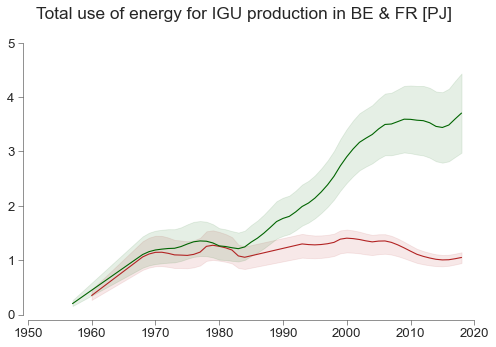

In [134]:
# Plot total energy use for IGU production in Belgium and France:
fig, ax = plt.subplots(figsize=(8, 5))

for country in countries:
    # Define the color:
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'darkgreen'

    ax.plot(df_be_fr.interpolate().rolling(5, center=True).mean()
            [('Total energy, production', '[PJ], average', country)],
            linewidth=1.1, c=color
            )

    ax.fill_between(df_be_fr.index,
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('Total energy, production',
                      '[PJ], max.', country)],
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('Total energy, production',
                      '[PJ], min.', country)],
                    alpha=0.10, color=color)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 5)
style_ax(ax)

fig.suptitle("Total use of energy for IGU production in BE & FR [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Absolute CO2 Emissions

In [135]:
# Estimate the CO2 emission related to IGU production:
for level in levels:
    for country in countries:
        df_be_fr[('co2, production', f"[kt], {level}", country)] = (
            df_be_fr[('Production', f"[kt], {level}", country)]
            * fr_co2_intensity['CO2 interpolated [kg/t]'] / 1000
        )

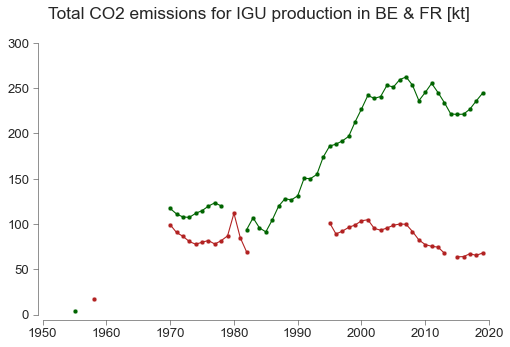

In [136]:
# Plot total CO2 emissions for IGU production in Belgium and France:
fig, ax = plt.subplots(figsize=(8, 5))

for country in countries:
    # Define the color:
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'darkgreen'

    ax.plot(df_be_fr[('co2, production', '[kt], average', country)],
            linewidth=1.1, color=color, linestyle='-'
            )

    sns.scatterplot(data=df_be_fr[('co2, production',
                                   '[kt], average', country)],
                    color=color, ax=ax)

    ax.yaxis.label.set_visible(False)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 300)
style_ax(ax)

fig.suptitle("Total CO2 emissions for IGU production in BE & FR [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

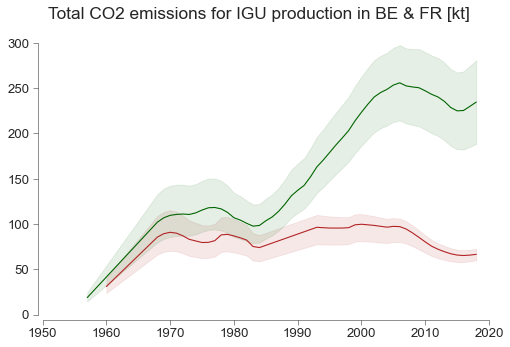

In [137]:
# Plot total CO2 emissions for IGU production in Belgium and France:
fig, ax = plt.subplots(figsize=(8, 5))

for country in countries:
    # Define the color:
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'darkgreen'

    ax.plot(df_be_fr.interpolate().rolling(5, center=True).mean()
            [('co2, production', '[kt], average', country)],
            linewidth=1.1, c=color
            )

    ax.fill_between(df_be_fr.index,
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('co2, production', '[kt], max.', country)],
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('co2, production', '[kt], min.', country)],
                    alpha=0.10, color=color)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 300)
style_ax(ax)

fig.suptitle("Total CO2 emissions for IGU production in BE & FR [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

# The Belgian and French Consumption of IGU: Environmental Analysis

## Raw Material Flows

In [138]:
# Absolute use of raw materials for IGU consumption:
for mat in materials:
    for level in levels:
        for country in countries:
            df_be_fr[(f"{mat}, consumption", f"[kt], {level}", country)] = (
                df_be_fr[('Consumption', f"[kt], {level}", country)]
                * (df_rawmat[(f"{mat}, kg/kg")]
                   .interpolate(method='pchip', limit_direction='forward'))
            )

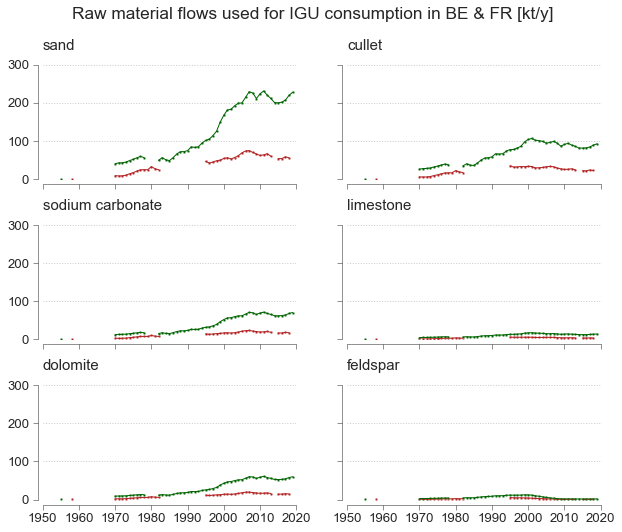

In [139]:
# Plot raw material flows for IGU consumption:
fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    for country in countries:
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'firebrick'
            ax.set_title(f"{mat}", loc='left', pad=15)
        else:
            color = 'darkgreen'

        ax.plot(df_be_fr[(f"{mat}, consumption", '[kt], average', country)],
                linewidth=1, c=color
                )

        sns.scatterplot(data=df_be_fr[(f"{mat}, consumption",
                                       '[kt], average', country)],
                        color=color, ax=ax, marker='.', s=30
                        )

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        ax.yaxis.label.set_visible(False)
        style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 300)
plt.yticks(np.arange(0, 301, 100))

fig.suptitle("Raw material flows used for IGU consumption in BE & FR [kt/y]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

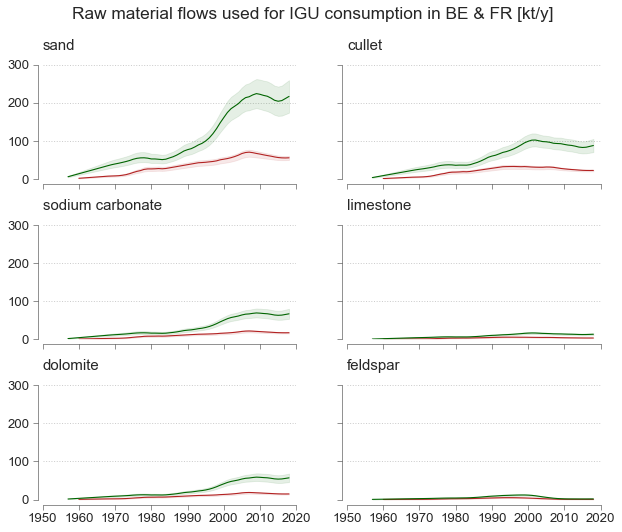

In [140]:
# Plot raw material flows for IGU consumption:
fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    for country in countries:
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'firebrick'
            ax.set_title(f"{mat}", loc='left', pad=15)
        else:
            color = 'darkgreen'

        ax.plot(df_be_fr.interpolate().rolling(5, center=True).mean()
                [(f"{mat}, consumption", '[kt], average', country)],
                linewidth=1.1, c=color
                )

        ax.fill_between(df_be_fr.index,
                        df_be_fr.interpolate().rolling(5, center=True).mean()
                        [(f"{mat}, consumption", '[kt], max.', country)],
                        df_be_fr.interpolate().rolling(5, center=True).mean()
                        [(f"{mat}, consumption", '[kt], min.', country)],
                        alpha=0.10, color=color)

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 300)
plt.yticks(np.arange(0, 301, 100))

fig.suptitle("Raw material flows used for IGU consumption in BE & FR [kt/y]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [141]:
# Estimate total use of raw materials (sum per material):
for level in levels:
    for country in countries:
        df_be_fr[('Total raw materials, consumption',
                  f'[kt], {level}', country)] = 0

for mat in materials:
    for level in levels:
        for country in countries:
            df_be_fr[('Total raw materials, consumption',
                      f'[kt], {level}', country)] = (
                df_be_fr[(f"{mat}, consumption",
                          f'[kt], {level}', country)]
                + df_be_fr[('Total raw materials, consumption',
                            f'[kt], {level}', country)]
            )

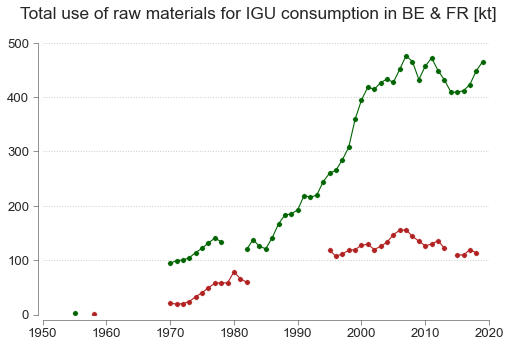

In [142]:
# Plot total material use for IGU consumption in Belgium and France:
fig, ax = plt.subplots(figsize=(8, 5))

for country in countries:
    # Define the color:
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'darkgreen'

    ax.plot(df_be_fr[('Total raw materials, consumption',
                      '[kt], average', country)],
            linewidth=1.1, c=color, linestyle='-'
            )

    sns.scatterplot(data=df_be_fr[('Total raw materials, consumption',
                              '[kt], average', country)],
                    color=color, s=30
                    )
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    ax.yaxis.label.set_visible(False)
    
ax.set_xlim(1950, 2020)
ax.set_ylim(0, 500)
style_ax(ax)

fig.suptitle("Total use of raw materials for IGU consumption in BE & FR [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

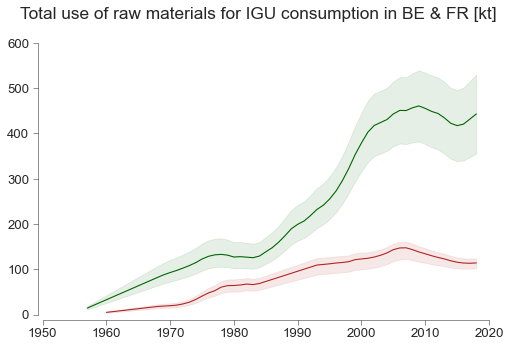

In [143]:
# Plot total material use for IGU consumption in Belgium and France:
fig, ax = plt.subplots(figsize=(8, 5))

for country in countries:
    # Define the color:
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'darkgreen'

    ax.plot(df_be_fr.interpolate().rolling(5, center=True).mean()
            [('Total raw materials, consumption', '[kt], average', country)],
            linewidth=1.1, c=color
            )

    ax.fill_between(df_be_fr.index,
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('Total raw materials, consumption',
                      '[kt], max.', country)],
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('Total raw materials, consumption',
                      '[kt], min.', country)],
                    alpha=0.10, color=color)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 600)
style_ax(ax)

fig.suptitle("Total use of raw materials for IGU consumption in BE & FR [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Energy Use

In [144]:
# Absolute use of energy for IGU consumption:
for energy in energies:
    for level in levels:
        for country in countries:
            df_be_fr[(f"{energy}, consumption", f"[PJ], {level}", country)] = (
                df_be_fr[('Consumption', f"[kt], {level}", country)]/1000
                * (df_be_fr_energy[(f"{energy}, GJ/t", country)]
                   .interpolate(method='pchip', limit_direction='forward'))
            )

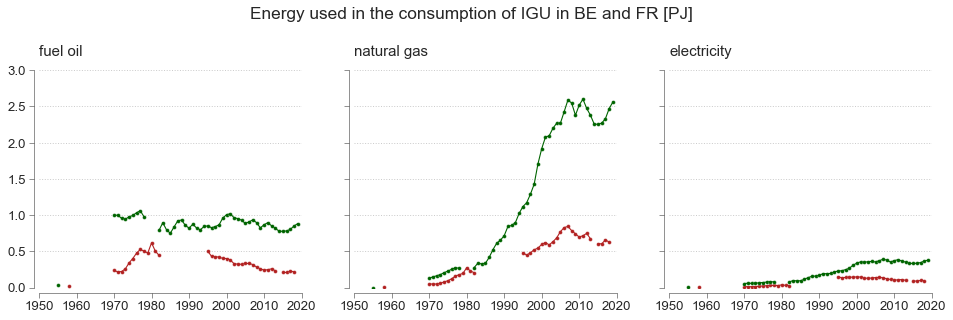

In [145]:
# Plot energy flows for IGU consumption:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    for country in countries:
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'firebrick'
            ax.set_title(f"{energy}", loc='left', pad=15)
        else:
            color = 'darkgreen'

        ax.plot(df_be_fr[(f"{energy}, consumption", '[PJ], average', country)],
                linewidth=1.1, c=color
                )

        sns.scatterplot(data=df_be_fr[(f"{energy}, consumption", 
                                  '[PJ], average', country)],
                color=color, ax=ax, s=15)
        
        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        ax.yaxis.label.set_visible(False)
        style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 3)
plt.yticks(np.arange(0, 3.1, 0.5))

fig.suptitle("Energy used in the consumption of IGU in BE and FR [PJ]", y=1.1)
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

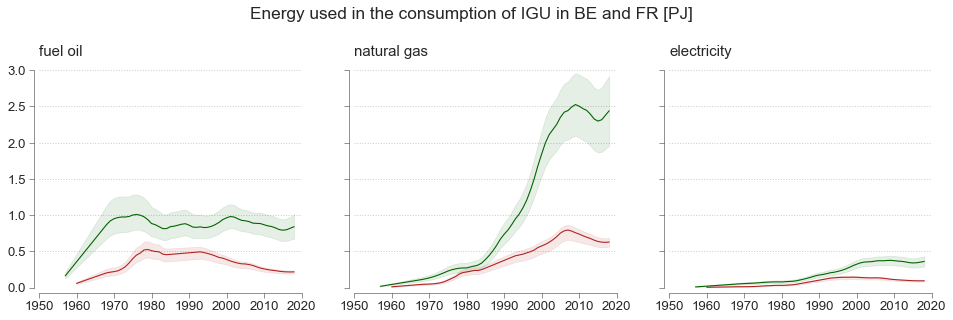

In [146]:
# Plot energy flows for IGU consumption:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    for country in countries:
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'firebrick'
            ax.set_title(f"{energy}", loc='left', pad=15)
        else:
            color = 'darkgreen'

        ax.plot(df_be_fr.interpolate().rolling(5, center=True).mean()
                [(f"{energy}, consumption", '[PJ], average', country)],
                linewidth=1.1, c=color
                )

        ax.fill_between(df_be_fr.index,
                        df_be_fr.interpolate().rolling(5, center=True).mean()
                        [(f"{energy}, consumption", '[PJ], max.', country)],
                        df_be_fr.interpolate().rolling(5, center=True).mean()
                        [(f"{energy}, consumption", '[PJ], min.', country)],
                        alpha=0.10, color=color)

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 3)
plt.yticks(np.arange(0, 3.1, 0.5))

fig.suptitle("Energy used in the consumption of IGU in BE and FR [PJ]", y=1.1)
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [147]:
# Estimate total energy use (sum per energy type):
for level in levels:
    for country in countries:
        df_be_fr[('Total energy, consumption', f'[PJ], {level}', country)] = 0

for energy in energies:
    for level in levels:
        for country in countries:
            df_be_fr[('Total energy, consumption',
                      f'[PJ], {level}', country)] = (
                df_be_fr[(f"{energy}, consumption", f'[PJ], {level}', country)]
                + df_be_fr[('Total energy, consumption',
                            f'[PJ], {level}', country)]
            )

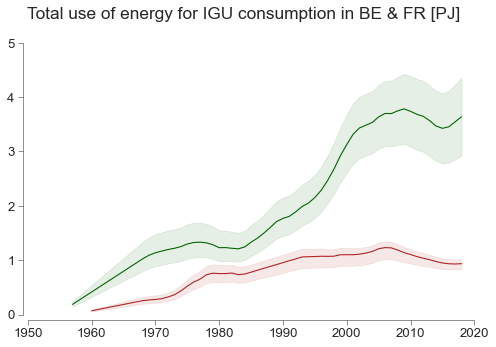

In [148]:
# Plot total energy use for IGU consumption in Belgium and France:
fig, ax = plt.subplots(figsize=(8, 5))

for country in countries:
    # Define the color:
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'darkgreen'

    ax.plot(df_be_fr.interpolate().rolling(5, center=True).mean()
            [('Total energy, consumption', '[PJ], average', country)],
            linewidth=1.1, c=color
            )

    ax.fill_between(df_be_fr.index,
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('Total energy, consumption',
                      '[PJ], max.', country)],
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('Total energy, consumption',
                      '[PJ], min.', country)],
                    alpha=0.10, color=color)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 5)
style_ax(ax)

fig.suptitle("Total use of energy for IGU consumption in BE & FR [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Absolute CO2 Emissions

In [149]:
# Estimate the CO2 emission related to IGU consumption:
for level in levels:
    for country in countries:
        df_be_fr[('co2, consumption', f"[kt], {level}", country)] = (
            df_be_fr[('Consumption', f"[kt], {level}", country)]
            * fr_co2_intensity['CO2 interpolated [kg/t]'] / 1000
        )

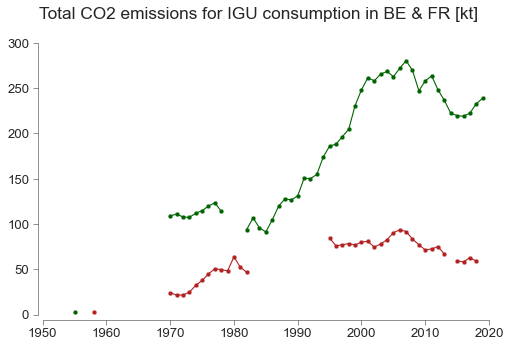

In [150]:
# Plot total CO2 emissions for IGU consumption in Belgium and France:
fig, ax = plt.subplots(figsize=(8, 5))

for country in countries:
    # Define the color:
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'darkgreen'

    ax.plot(df_be_fr[('co2, consumption', '[kt], average', country)],
            linewidth=1.1, color=color, linestyle='-'
            )

    sns.scatterplot(data=df_be_fr[('co2, consumption',
                                   '[kt], average', country)],
                    color=color, ax=ax)

    ax.yaxis.label.set_visible(False)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 300)
style_ax(ax)

fig.suptitle("Total CO2 emissions for IGU consumption in BE & FR [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

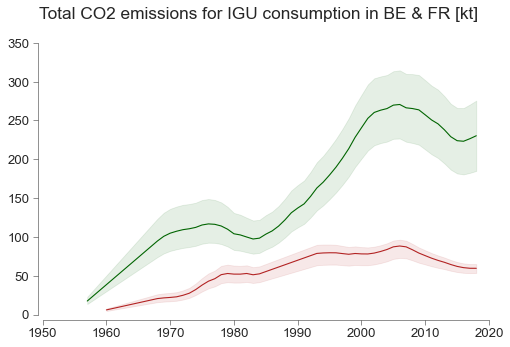

In [151]:
# Plot total CO2 emissions for IGU consumption in Belgium and France:
fig, ax = plt.subplots(figsize=(8, 5))

for country in countries:
    # Define the color:
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'darkgreen'

    ax.plot(df_be_fr.interpolate().rolling(5, center=True).mean()
            [('co2, consumption', '[kt], average', country)],
            linewidth=1.1, c=color
            )

    ax.fill_between(df_be_fr.index,
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('co2, consumption', '[kt], max.', country)],
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('co2, consumption', '[kt], min.', country)],
                    alpha=0.10, color=color)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 350)
style_ax(ax)

fig.suptitle("Total CO2 emissions for IGU consumption in BE & FR [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Summary

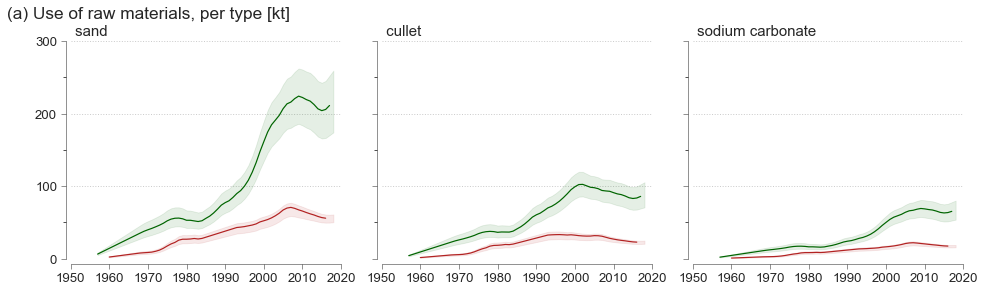

In [161]:
# Raw materials, per type:
mat_reduced = ['sand', 'cullet', 'sodium carbonate']

fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, mat) in enumerate(zip(axes.flatten(), mat_reduced)):
    for country in countries:
        if country == 'Belgium':
            color = 'firebrick'
            ax.set_title(f" {mat}", loc='left')
        else:
            color = 'darkgreen'

        (df_be_fr[(f"{mat}, consumption", '[kt], average', country)]
         .interpolate(method="linear", limit_area='inside')
         .rolling(5, center=True).mean()
         .plot(ax=ax, c=color))

        ax.fill_between(df_be_fr.index,
                        df_be_fr.interpolate().rolling(5, center=True).mean()
                        [(f"{mat}, consumption", '[kt], max.', country)],
                        df_be_fr.interpolate().rolling(5, center=True).mean()
                        [(f"{mat}, consumption", '[kt], min.', country)],
                        alpha=0.10, color=color)

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 300)
plt.xticks(np.arange(1950, 2021, 10))
plt.yticks(np.arange(0, 301, 100))

fig.suptitle("(a) Use of raw materials, per type [kt]",
             x=0.07, y=1, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

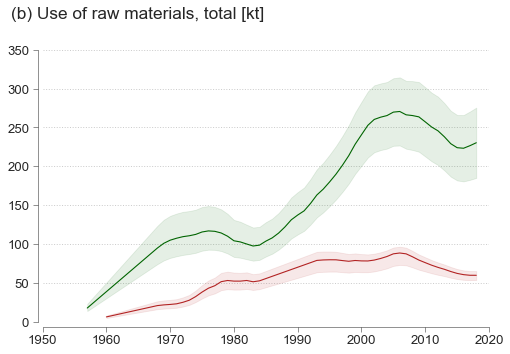

In [165]:
# Raw materials, total:
fig, ax = plt.subplots(figsize=(8, 5))

for country in countries:
    # Define the color:
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'darkgreen'

    ax.plot(df_be_fr.interpolate().rolling(5, center=True).mean()
            [('co2, consumption', '[kt], average', country)],
            linewidth=1.1, c=color
            )

    ax.fill_between(df_be_fr.index,
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('co2, consumption', '[kt], max.', country)],
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('co2, consumption', '[kt], min.', country)],
                    alpha=0.10, color=color)

    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))

ax.set_ylim(0, 350)
plt.yticks(np.arange(0, 351, 50))

fig.suptitle("(b) Use of raw materials, total [kt]", x=0.07, y=1, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

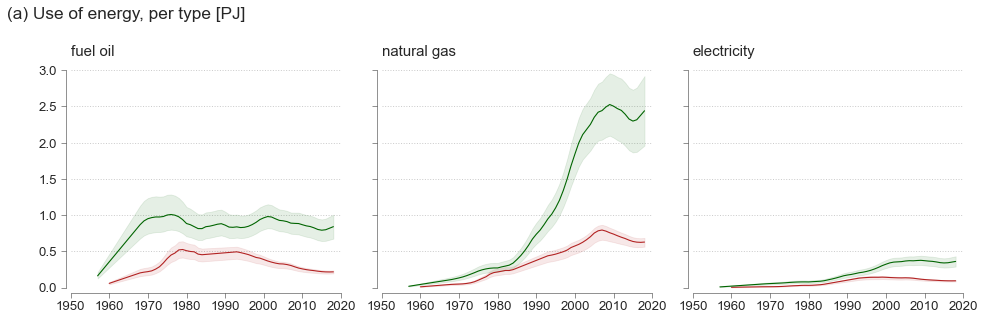

In [170]:
# Energy use, per type:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    for country in countries:
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'firebrick'
            ax.set_title(f"{energy}", loc='left', pad=15)
        else:
            color = 'darkgreen'

        ax.plot(df_be_fr.interpolate().rolling(5, center=True).mean()
                [(f"{energy}, consumption", '[PJ], average', country)],
                linewidth=1.1, c=color
                )

        ax.fill_between(df_be_fr.index,
                        df_be_fr.interpolate().rolling(5, center=True).mean()
                        [(f"{energy}, consumption", '[PJ], max.', country)],
                        df_be_fr.interpolate().rolling(5, center=True).mean()
                        [(f"{energy}, consumption", '[PJ], min.', country)],
                        alpha=0.10, color=color)

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 3)

plt.xticks(np.arange(1950, 2021, 10))

fig.suptitle("(a) Use of energy, per type [PJ]", x=0.07, y=1.1, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

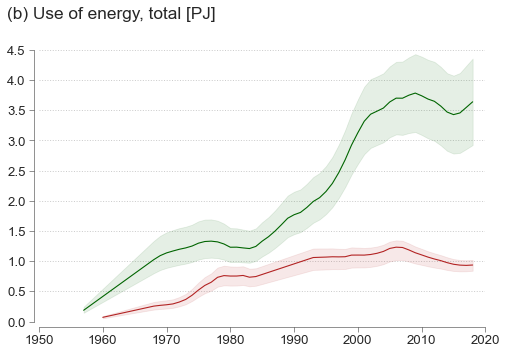

In [175]:
# Energy use, total:
fig, ax = plt.subplots(figsize=(8, 5))

for country in countries:
    # Define the color:
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'darkgreen'

    ax.plot(df_be_fr.interpolate().rolling(5, center=True).mean()
            [('Total energy, consumption', '[PJ], average', country)],
            linewidth=1.1, c=color
            )

    ax.fill_between(df_be_fr.index,
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('Total energy, consumption',
                      '[PJ], max.', country)],
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('Total energy, consumption',
                      '[PJ], min.', country)],
                    alpha=0.10, color=color)

    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))

ax.set_ylim(0, 4.5)
plt.yticks(np.arange(0, 4.6, 0.5))

fig.suptitle("(b) Use of energy, total [PJ]", x=0.07, y=1, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

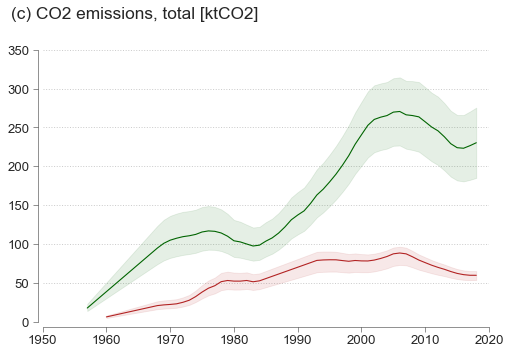

In [181]:
# CO2 emissions, total:
fig, ax = plt.subplots(figsize=(8, 5))

for country in countries:
    # Define the color:
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'darkgreen'

    ax.plot(df_be_fr.interpolate().rolling(5, center=True).mean()
            [('co2, consumption', '[kt], average', country)],
            linewidth=1.1, c=color
            )

    ax.fill_between(df_be_fr.index,
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('co2, consumption', '[kt], max.', country)],
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('co2, consumption', '[kt], min.', country)],
                    alpha=0.10, color=color)

    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 350)
plt.yticks(np.arange(0, 351, 50))

fig.suptitle("(c) CO2 emissions, total [ktCO2]", x=0.07, y=1, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

# Figures for publication

## Glass Thickness in Insulating Glass Units

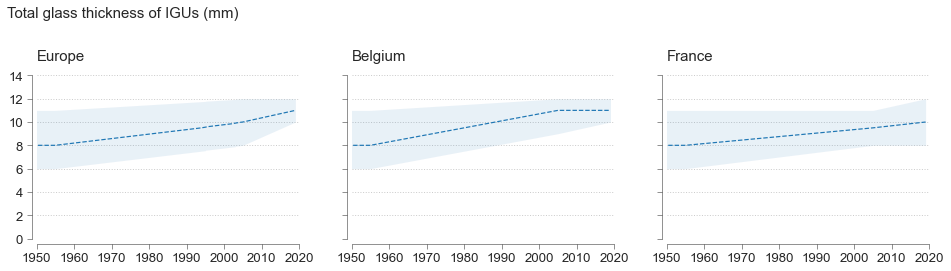

In [204]:
regions = ['Europe', 'Belgium', 'France']

fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 3))

for i, (ax, region) in enumerate(zip(axes.flatten(), regions)):
    if region == 'Europe':
        sns.lineplot(data=df_eu_thick.reset_index('Nbr of countries').drop(
            labels='Nbr of countries', axis=1)['average thickness, mm'],
            linestyle='--', ax=ax)

        ax.fill_between(df_toplot.index, df_toplot['max. thickness, mm'],
                        df_toplot['min. thickness, mm'],
                        alpha=0.10)
    else:
        sns.lineplot(data=df_be_fr_thick[('average thickness, mm', region)],
                     linestyle='--', ax=ax)

        ax.fill_between(df_be_fr_thick.index,
                        df_be_fr_thick[('max. thickness, mm', region)],
                        df_be_fr_thick[('min. thickness, mm', region)],
                        alpha=0.10)

    ax.set_title(region, loc='left', pad=15)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)

    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 14)
plt.yticks(np.arange(0, 15, 2))

fig.suptitle('Total glass thickness of IGUs (mm)', fontsize=15, y=1.2, x=0.2)
sns.despine(offset=5)

if export:
    # Save image:
    plt.savefig(os.path.join(path_img, 'Fig1_EU-BE-FR_IGU-Thickness.png'),
                dpi=600, bbox_inches='tight')
    plt.savefig(os.path.join(path_img, 'Fig1_EU-BE-FR_IGU-Thickness.pdf'),
                bbox_inches='tight')


## MEFA, Europe

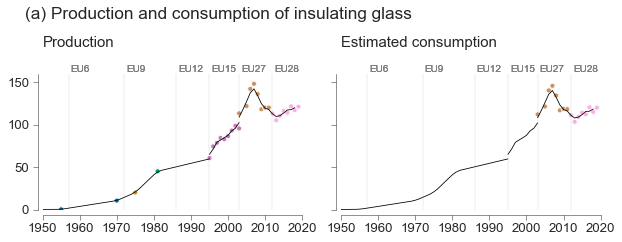

In [256]:
# Plot two figures:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 2.5))

for col, data in enumerate(['Production', 'Estimated consumption']):
    for i, j in EU_COUNTRIES:
        ax = axes[col]
        # Plot the trend curve for IGU production:
        ax.plot(df_eu.interpolate().rolling(3, center=True).mean().loc[i:j]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [(f"{data}", "[10^6 m²]")],
                c='black', linewidth=0.8, linestyle='-')

        if col == 0:
            # Plot data gathered from literature review:
            sns.scatterplot(data=df_eu["Production"].reset_index(),
                            x='year', y="[10^6 m²]",
                            hue='Nbr of countries',
                            palette='colorblind',
                            marker='.', s=100,
                            ax=ax)

        else:
            # Plot data gathered from literature review:
            sns.scatterplot(data=df_eu["Consumption"].reset_index(),
                            x='year', y="[10^6 m²]",
                            hue='Nbr of countries',
                            palette='colorblind',
                            marker='.', s=100,
                            ax=ax)
        
        # Plot lines highlighting changes in the scope, i.e., EU enlargement:
        for y, x in EU_KDATES.items():
            ax.axvline(x=x, c='grey', linestyle=':', linewidth=0.1)
            ax.text(x+0.5, 170, f"{y}", fontsize=10,
                    verticalalignment='top', color='grey')

        style_ax(ax)
        ax.yaxis.label.set_visible(False)
        ax.xaxis.label.set_visible(False)
        ax.get_legend().remove()
        ax.set_title(f'{data}', loc='left', y=1.15)

ax.set_ylim(0, 160)
ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))

fig.suptitle("(a) Production and consumption of insulating glass",
             x=0.1, y=1.25, ha='left')

fig.subplots_adjust(wspace=0.15)
sns.despine(offset=5)

if export:
    # Save image:
    plt.savefig(os.path.join(path_img, 'Fig2a_EU_IGUFlows.png'),
                dpi=600, bbox_inches='tight')
    plt.savefig(os.path.join(path_img, 'Fig2a_EU_IGUFlows.pdf'),
                bbox_inches='tight')

plt.show()

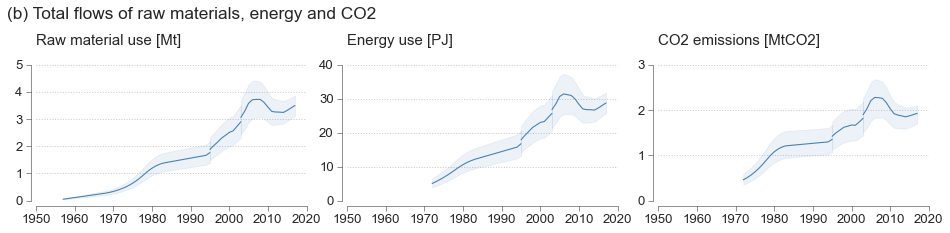

In [280]:
# Plot total energy & material use, total CO2 emissions for IGU consumption:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True,
                         figsize=(16, 2.5))

# Total use of raw materials:
ax = axes[0]
for a, b in EU_COUNTRIES:
    ax.plot(df_eu.interpolate().rolling(5, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('Total raw materials, consumption', '[Mt], average')],
            linewidth=1.1, c='steelblue', linestyle='-')

    ax.fill_between(df_eu.loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year']).index,
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [("Total raw materials, consumption", '[Mt], max.')],
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [("Total raw materials, consumption", '[Mt], min.')],
                    alpha=0.10, color='steelblue')

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_title("Raw material use [Mt]", loc='left', y=1.1)
style_ax(ax)
ax.set_ylim(0, 5)
ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))

# Total use of energy:
ax = axes[1]
for a, b in EU_COUNTRIES:
    ax.plot(df_eu.interpolate().rolling(5, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('Total energy, consumption', '[PJ], average')],
            linewidth=1.1, c='steelblue', linestyle='-')

    ax.fill_between(df_eu.loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year']).index,
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [("Total energy, consumption", '[PJ], max.')],
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [("Total energy, consumption", '[PJ], min.')],
                    alpha=0.10, color='steelblue')

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_title("Energy use [PJ]", loc='left', y=1.1)
style_ax(ax)
ax.set_ylim(0, 40)

# Total emissions of CO2:
ax = axes[2]
for a, b in EU_COUNTRIES:
    ax.plot(df_eu.interpolate().rolling(5, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('co2, production', '[kt], average')],
            linewidth=1.1, c='steelblue', linestyle='-')

    ax.fill_between(df_eu.loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year']).index,
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [('co2, consumption', '[kt], max.')],
                    df_eu.interpolate().rolling(5, center=True).mean()
                    .loc[a:b].reset_index(level='Nbr of countries')
                    .sort_values(by=['year'])
                    [('co2, consumption', '[kt], min.')],
                    alpha=0.10, color='steelblue')

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

# Divide by 1000 the y-axis, results in Mt
ax.yaxis.set_major_formatter(y_1000)

ax.set_title("CO2 emissions [MtCO2]", loc='left', y=1.1)
style_ax(ax)
ax.set_ylim(0, 3000)

fig.suptitle("(b) Total flows of raw materials, energy and CO2",
             x=0.1, y=1.2, ha='left')
fig.subplots_adjust(wspace=0.15)

sns.despine(offset=5)

if export:
    # Save image:
    plt.savefig(os.path.join(path_img, 'Fig2b_EU_TotalFlows.png'),
                dpi=600, bbox_inches='tight')
    plt.savefig(os.path.join(path_img, 'Fig2b_EU_TotalFlows.pdf'),
                bbox_inches='tight')

plt.show()

## MEFA, Belgium and France

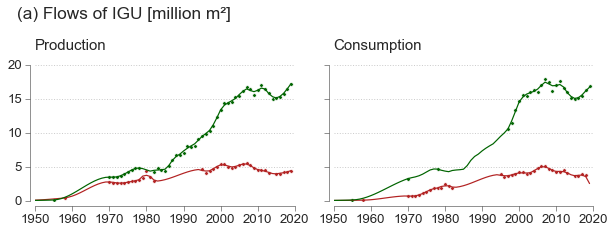

In [277]:
# Plot total flows, moving average w/ a 3-y. window length:
toplot = ['Production', 'Consumption']

fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 2.5))

for data in toplot:
    if data == "Production":
        ax = axes[0]
    if data == "Consumption":
        ax = axes[1]

    for country in countries:
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'firebrick'
            ax.set_title(f"{data}", loc='left', pad=15)
        else:
            color = 'darkgreen'

        (df_be_fr[(data, "[10^6 m²]", country)]
         .interpolate(method='pchip').rolling(3, center=True).mean()
         .plot(ax=ax, c=color)
         )
        
        # Plot raw data:
        sns.scatterplot(data=df_be_fr_init[data, "[10^6 m²]", country],
                        marker='.', s=50, color=color,
                        ax=ax)
        ax.minorticks_off()
        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)
        ax.get_legend().remove()
        ax.set_ylabel(None)

        if row == 0:
            ax.set_title(country, y=1.25)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 20)
plt.yticks(np.arange(0, 21, 5))

fig.subplots_adjust(wspace=0.15, hspace=0.5)
fig.suptitle("(a) Flows of IGU [million m²]", x=0.1, y=1.2, ha='left')
sns.despine(offset=5)

if export:
    # Save image:
    plt.savefig(os.path.join(path_img, 'Fig3a_BE-FR_IGUFlows.png'),
                dpi=600, bbox_inches='tight')
    plt.savefig(os.path.join(path_img, 'Fig3a_BE-FR_IGUFlows.pdf'),
                bbox_inches='tight')

plt.show()

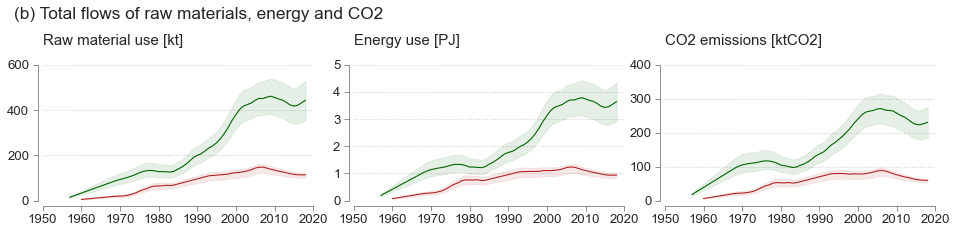

In [296]:
# Plot total energy & material use, total CO2 emissions for IGU consumption:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True,
                         figsize=(16, 2.5))

# Total use of raw materials:
ax = axes[0]
for country in countries:
    # Define the color:
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'darkgreen'

    ax.plot(df_be_fr.interpolate().rolling(5, center=True).mean()
            [('Total raw materials, consumption', '[kt], average', country)],
            linewidth=1.1, c=color
            )

    ax.fill_between(df_be_fr.index,
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('Total raw materials, consumption',
                      '[kt], max.', country)],
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('Total raw materials, consumption',
                      '[kt], min.', country)],
                    alpha=0.10, color=color)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_title("Raw material use [kt]", loc='left', y=1.1)
style_ax(ax)
ax.set_ylim(0, 600)
plt.xticks(np.arange(0, 601, 100))
ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))

# Total use of energy:
ax = axes[1]
for country in countries:
    # Define the color:
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'darkgreen'

    ax.plot(df_be_fr.interpolate().rolling(5, center=True).mean()
            [('Total energy, consumption', '[PJ], average', country)],
            linewidth=1.1, c=color
            )

    ax.fill_between(df_be_fr.index,
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('Total energy, consumption',
                      '[PJ], max.', country)],
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('Total energy, consumption',
                      '[PJ], min.', country)],
                    alpha=0.10, color=color)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_title("Energy use [PJ]", loc='left', y=1.1)
style_ax(ax)
ax.set_ylim(0, 5)

# Total emissions of CO2:
ax = axes[2]
for country in countries:
    # Define the color:
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'darkgreen'

    ax.plot(df_be_fr.interpolate().rolling(5, center=True).mean()
            [('co2, consumption', '[kt], average', country)],
            linewidth=1.1, c=color
            )

    ax.fill_between(df_be_fr.index,
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('co2, consumption', '[kt], max.', country)],
                    df_be_fr.interpolate().rolling(5, center=True).mean()
                    [('co2, consumption', '[kt], min.', country)],
                    alpha=0.10, color=color)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_title("CO2 emissions [ktCO2]", loc='left', y=1.1)
style_ax(ax)
ax.set_ylim(0, 400)
plt.yticks(np.arange(0, 401, 100))

fig.suptitle("(b) Total flows of raw materials, energy and CO2",
             x=0.1, y=1.2, ha='left')
fig.subplots_adjust(wspace=0.15)

sns.despine(offset=5)

if export:
    # Save image:
    plt.savefig(os.path.join(path_img, 'Fig3b_BE-FR_TotalFlows.png'),
                dpi=600, bbox_inches='tight')
    plt.savefig(os.path.join(path_img, 'Fig3b_BE-FR_TotalFlows.pdf'),
                bbox_inches='tight')

plt.show()